In [1]:
library(tidyverse)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


In [2]:
options(repr.matrix.max.rows=10)
options(repr.plot.height=10,
        repr.plot.width=10)

In [3]:
source("utility.R")
source("recommender.r")


Attaching package: 'assertthat'

The following object is masked from 'package:tibble':

    has_name



### Generate Preference

In [4]:
preference = generate_preference(list(unif=generate_uniform, ibp=generate_IBP), list(list(943, 1682, 0.1), list(943, 1682 * 0.1)) )

sampled 174239 interactions for 943 users in 0.340787887573242 seconds


### Sample Observation

In [5]:
observation = sample_obseravation(preference, list(unif=sample_uniform, popular=sample_popular), list(0.1))

Joining, by = "itemId"
Joining, by = "itemId"


### Build Recommenders and Compute Metrics

In [6]:
eval.results = build_recommender(preference, observation, partitionParam = list(5, 5),
                                 recommenders=list(oracle=recommend_oracle, 
                                                   popular=recommend_popular,
                                                   random=recommend_random),
                                 evalMetrics=list(compute_ndcg, compute_precision, compute_recall,
                                                  compute_average_precision, compute_reciprocal_rank, compute_hit_rate))

In [7]:
eval.results

strategy,part,algorithm,evaluation,userId,ndcg,precision,recall,avg.precision,reciprocal.rank,hit
ibp-popular,1,oracle,observation,4,0.00000000,0.0,0.00000000,NA,NA,FALSE
ibp-popular,1,oracle,observation,5,0.00000000,0.0,0.00000000,NA,NA,FALSE
ibp-popular,1,oracle,observation,7,0.00000000,0.0,0.00000000,NA,NA,FALSE
ibp-popular,1,oracle,observation,32,0.07362322,0.1,0.05555556,0.1666667,0.1666667,TRUE
ibp-popular,1,oracle,observation,51,0.00000000,0.0,0.00000000,NA,NA,FALSE
...,...,...,...,...,...,...,...,...,...,...
unif-unif,5,random,groundtruth,925,0.1903133,0.1,0.006172840,1.0000000,1.0000000,TRUE
unif-unif,5,random,groundtruth,926,0.0000000,0.0,0.000000000,NA,NA,FALSE
unif-unif,5,random,groundtruth,927,0.0000000,0.0,0.000000000,NA,NA,FALSE
unif-unif,5,random,groundtruth,932,0.0000000,0.0,0.000000000,NA,NA,FALSE


### Compute Error

In [8]:
eval.results.tall = eval.results %>%
    gather("metric", "score", -one_of(c("strategy", "part", "algorithm", "evaluation", "userId"))) %>%
    spread(evaluation, score) %>%
    mutate(groundtruth = ifelse(is.na(groundtruth), 0, groundtruth),
           observation = ifelse(is.na(observation), 0, observation)) %>%
    mutate(error = groundtruth - observation) 

mean.error = eval.results.tall %>%
    group_by(strategy, algorithm, metric, part) %>%
    summarize(ME = mean(error),
              MAE = mean(abs(error)),
              RMSE = sqrt(mean(error^2))) %>%
    ungroup() %>%
    group_by(strategy, algorithm, metric) %>%
    summarize(ME = mean(ME),
              MAE = mean(MAE),
              RMSE = mean(RMSE))

eval.results.plot = eval.results.tall %>%
    gather("type", "score", one_of(c('groundtruth','observation','error')))

In [9]:
eval.results.plot

strategy,part,algorithm,userId,metric,type,score
ibp-popular,1,oracle,4,avg.precision,groundtruth,1.00000000
ibp-popular,1,oracle,4,hit,groundtruth,1.00000000
ibp-popular,1,oracle,4,ndcg,groundtruth,1.00000000
ibp-popular,1,oracle,4,precision,groundtruth,1.00000000
ibp-popular,1,oracle,4,recall,groundtruth,0.05681818
...,...,...,...,...,...,...
unif-unif,5,random,941,hit,error,1.000000000
unif-unif,5,random,941,ndcg,error,0.120074301
unif-unif,5,random,941,precision,error,0.100000000
unif-unif,5,random,941,recall,error,0.005882353


In [10]:
unique(eval.results.tall$strategy)

[1] "ibp-popular"  "ibp-unif"     "unif-popular" "unif-unif"

In [11]:
unique(eval.results.tall$metric)

[1] "avg.precision"   "hit"             "ndcg"            "precision"      
[5] "recall"          "reciprocal.rank"

## nDCG

In [12]:
mean.error %>%
    filter(metric=="ndcg")

strategy,algorithm,metric,ME,MAE,RMSE
ibp-popular,oracle,ndcg,0.9530784,0.9530784,0.9560525
ibp-popular,popular,ndcg,0.9086831,0.9086831,0.9138784
ibp-popular,random,ndcg,0.3044248,0.3044248,0.3451149
ibp-unif,oracle,ndcg,0.9692605,0.9692605,0.9712660
ibp-unif,popular,ndcg,0.8731648,0.8731648,0.8812863
...,...,...,...,...,...
unif-popular,popular,ndcg,0.09443159,0.09443159,0.1387484
unif-popular,random,ndcg,0.09378007,0.09378007,0.1387277
unif-unif,oracle,ndcg,0.96799799,0.96799799,0.9703735
unif-unif,popular,ndcg,0.08987484,0.08987484,0.1349526


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


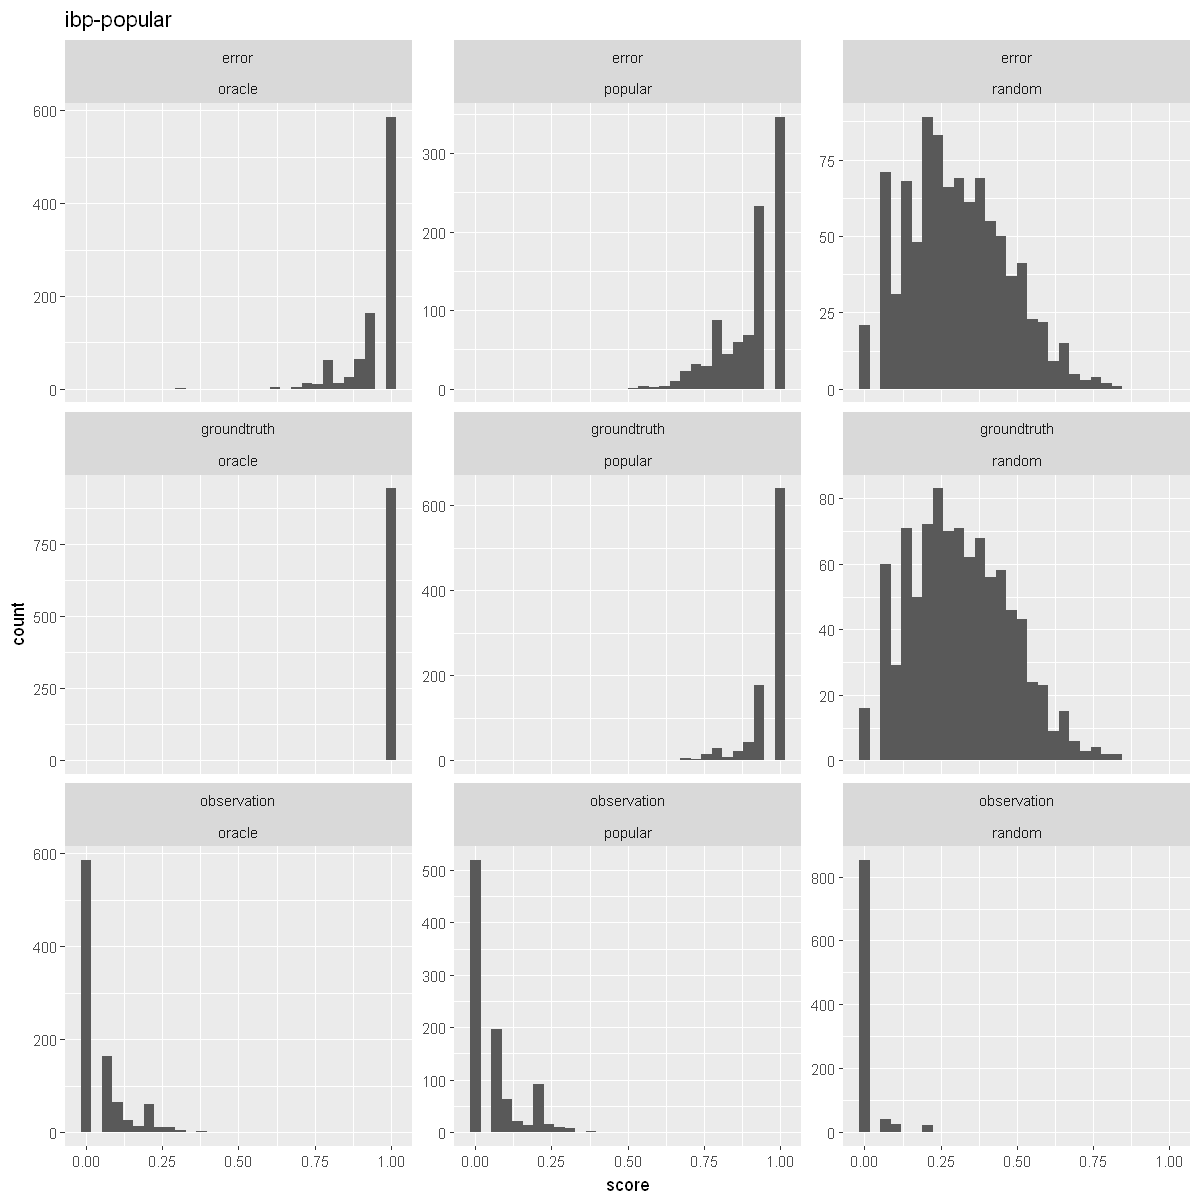

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


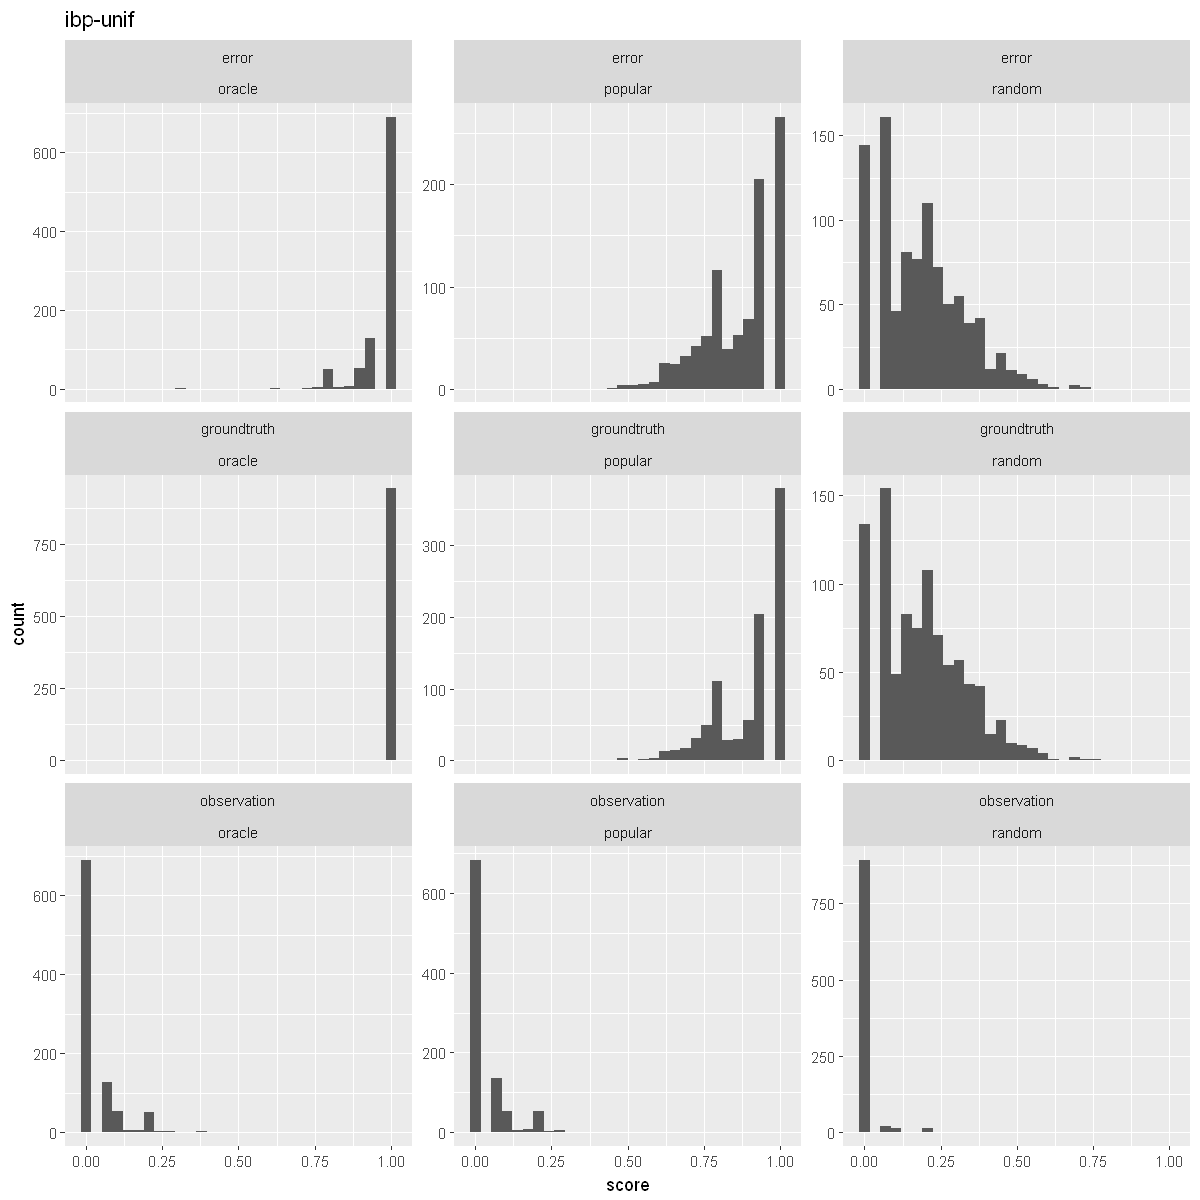

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


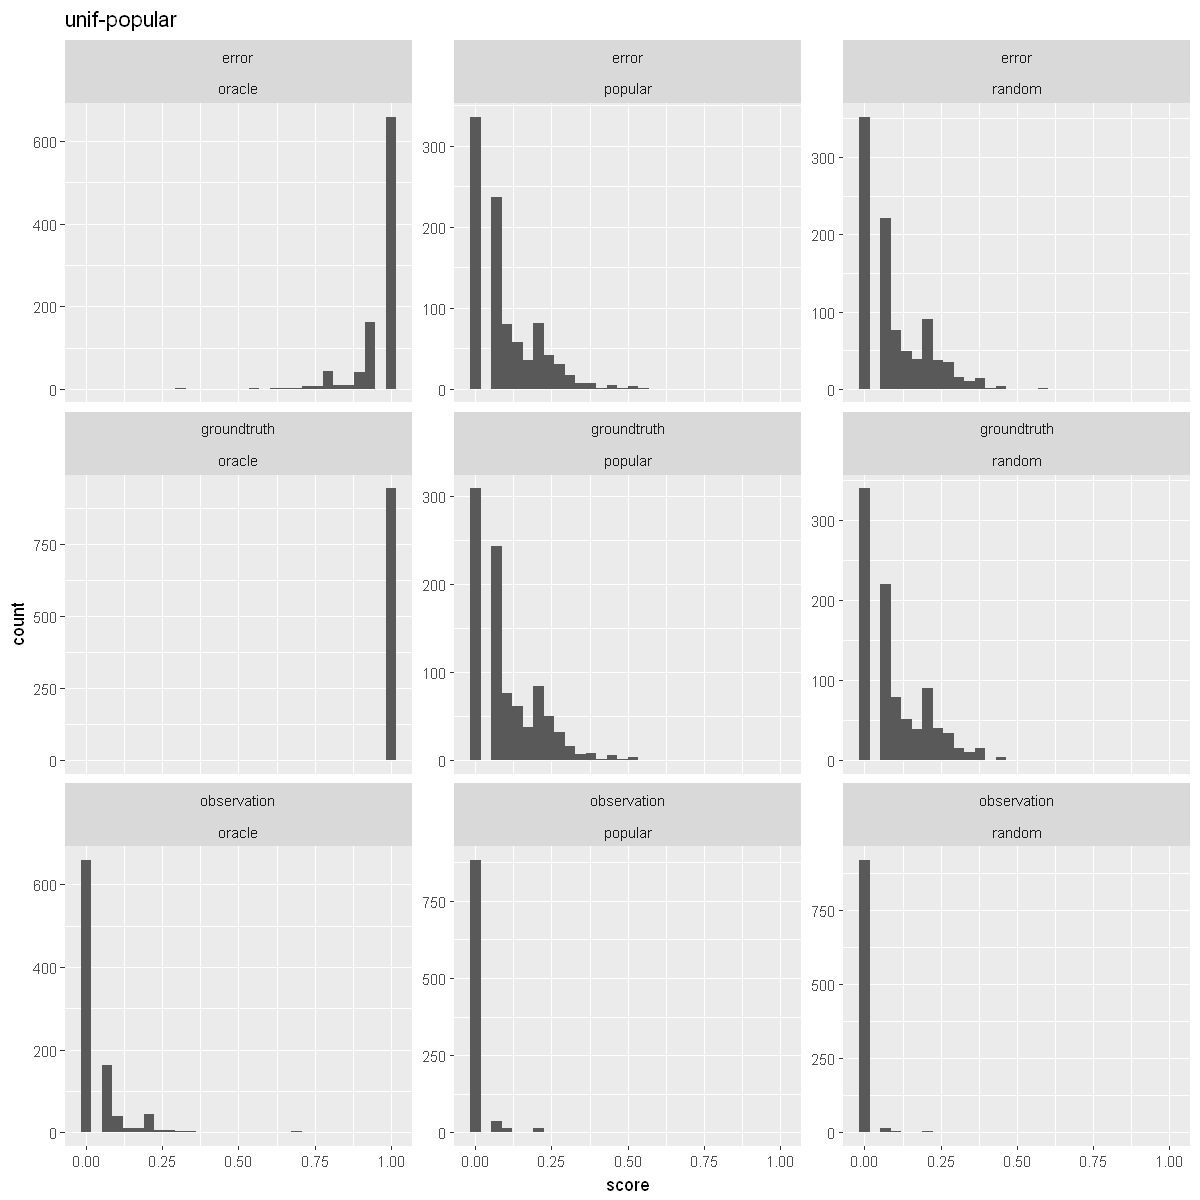

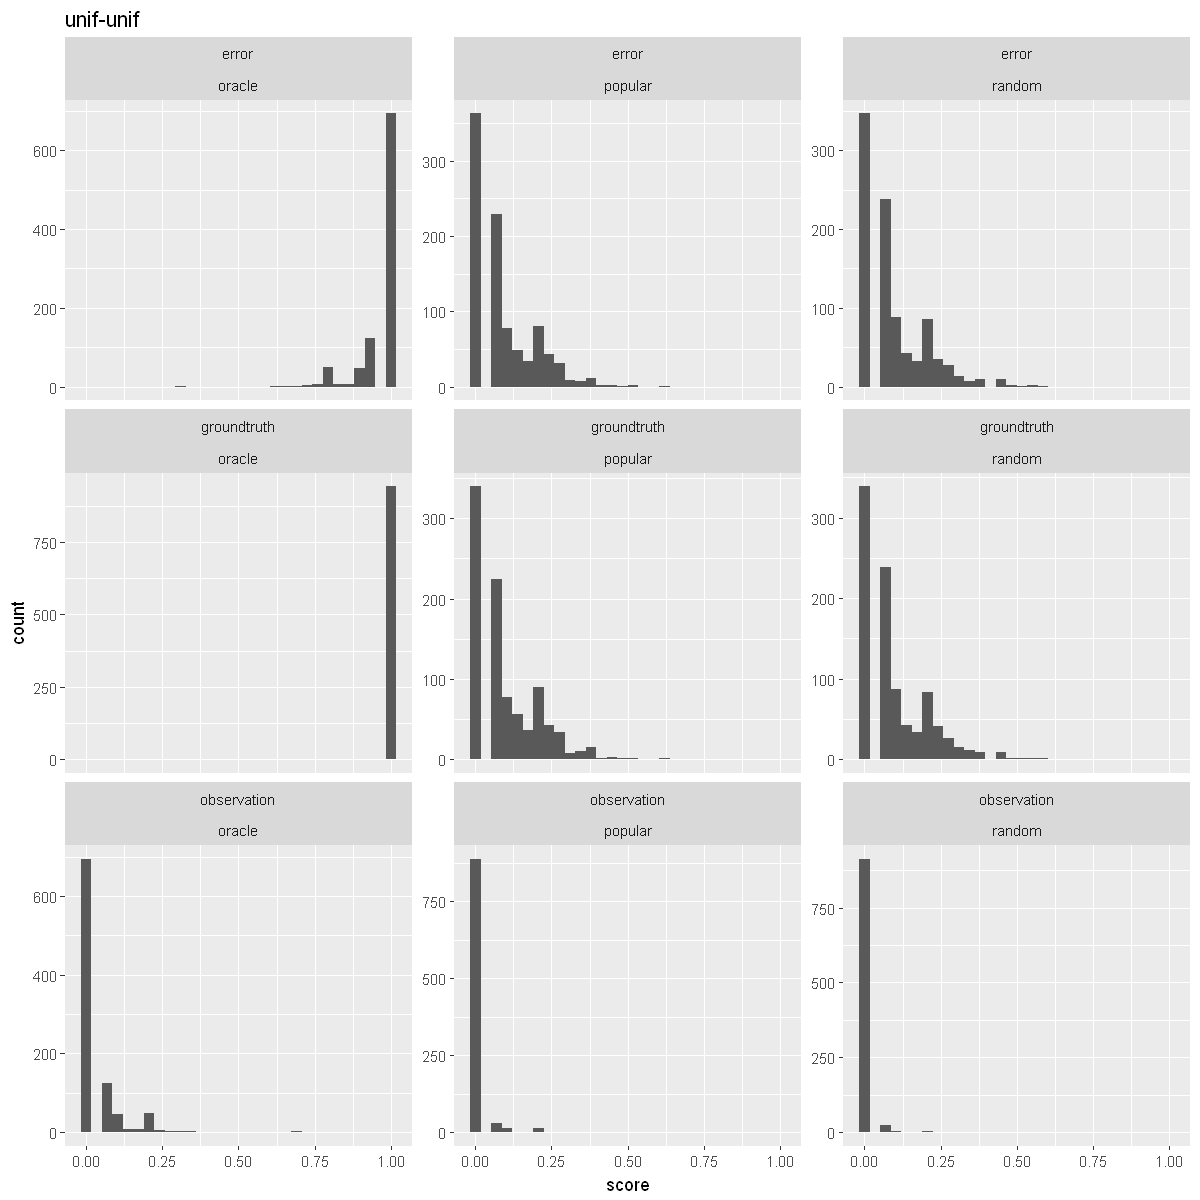

In [13]:
ggplot(filter(eval.results.plot, metric=="ndcg", strategy=='ibp-popular')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "ibp-popular")

ggplot(filter(eval.results.plot, metric=="ndcg", strategy=='ibp-unif')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "ibp-unif")

ggplot(filter(eval.results.plot, metric=="ndcg", strategy=='unif-popular')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "unif-popular")

ggplot(filter(eval.results.plot, metric=="ndcg", strategy=='unif-unif')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "unif-unif")

## Precision

In [14]:
mean.error %>%
    filter(metric=="precision")

strategy,algorithm,metric,ME,MAE,RMSE
ibp-popular,oracle,precision,0.9532354,0.9532354,0.9555780
ibp-popular,popular,precision,0.9057407,0.9057407,0.9102046
ibp-popular,random,precision,0.3067804,0.3067804,0.3401941
ibp-unif,oracle,precision,0.9697771,0.9697771,0.9712999
ibp-unif,popular,precision,0.8815316,0.8815316,0.8875504
...,...,...,...,...,...
unif-popular,popular,precision,0.09565744,0.09565744,0.1315806
unif-popular,random,precision,0.09353428,0.09353428,0.1306637
unif-unif,oracle,precision,0.96871384,0.96871384,0.9706484
unif-unif,popular,precision,0.09067939,0.09067939,0.1292659


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


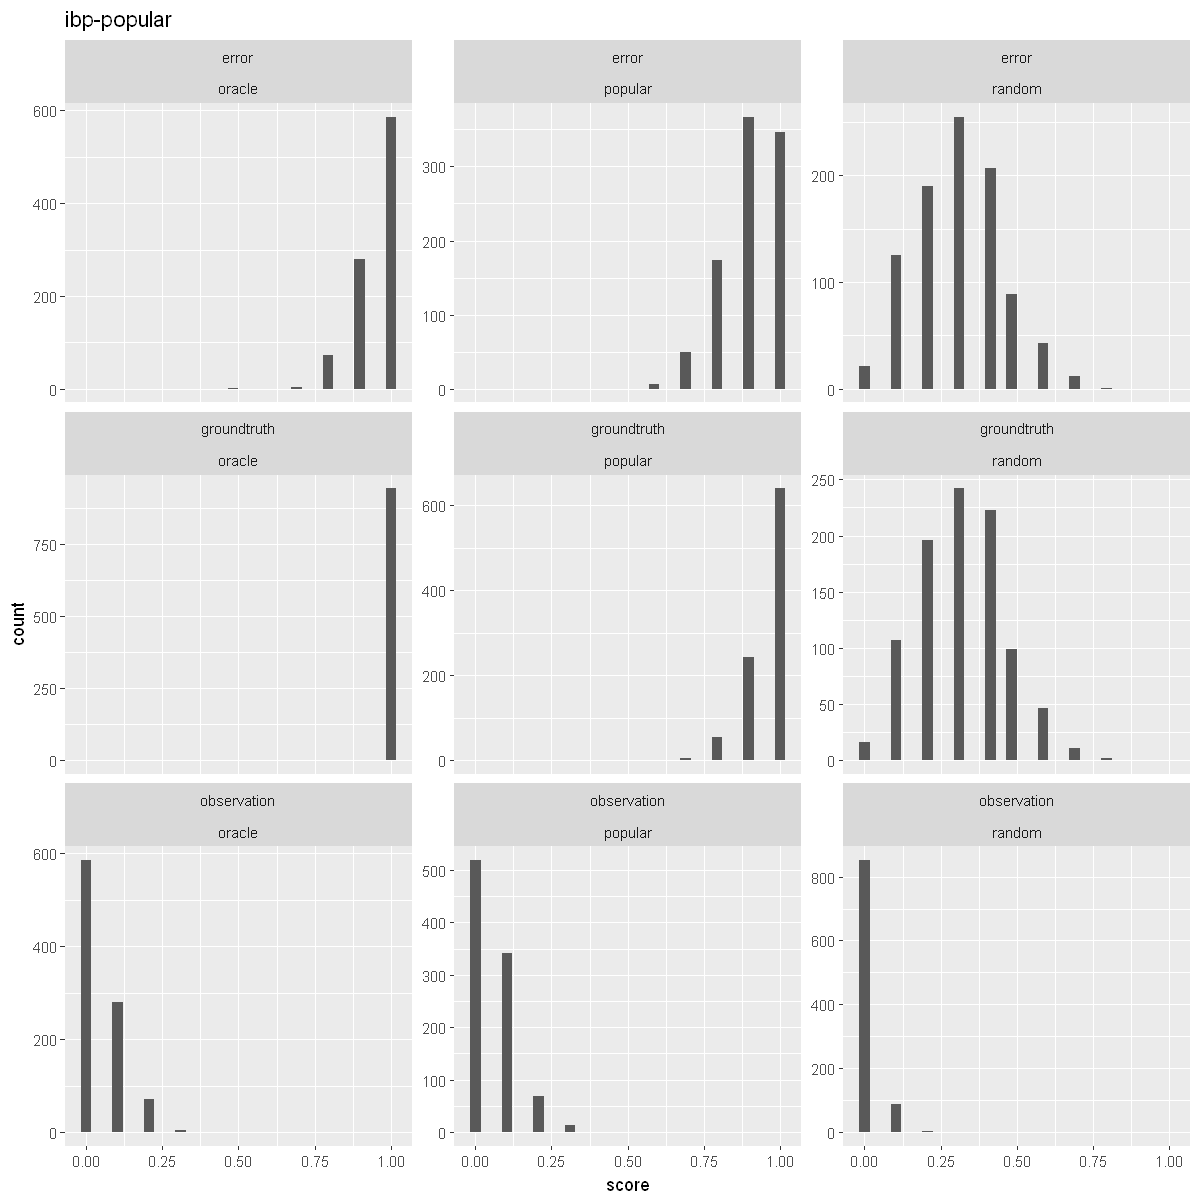

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


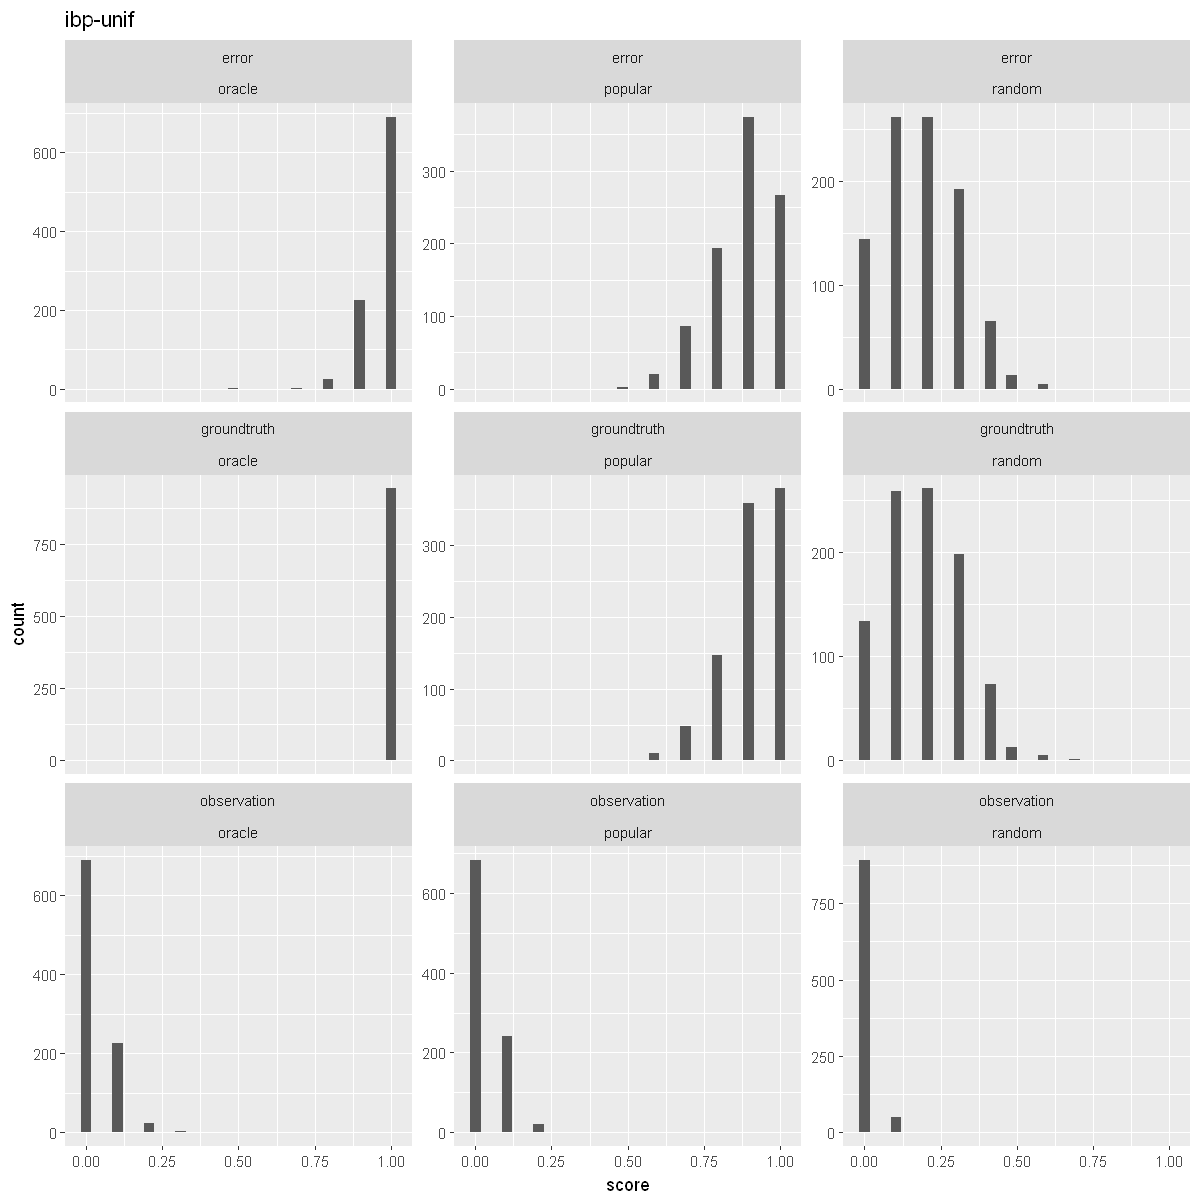

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


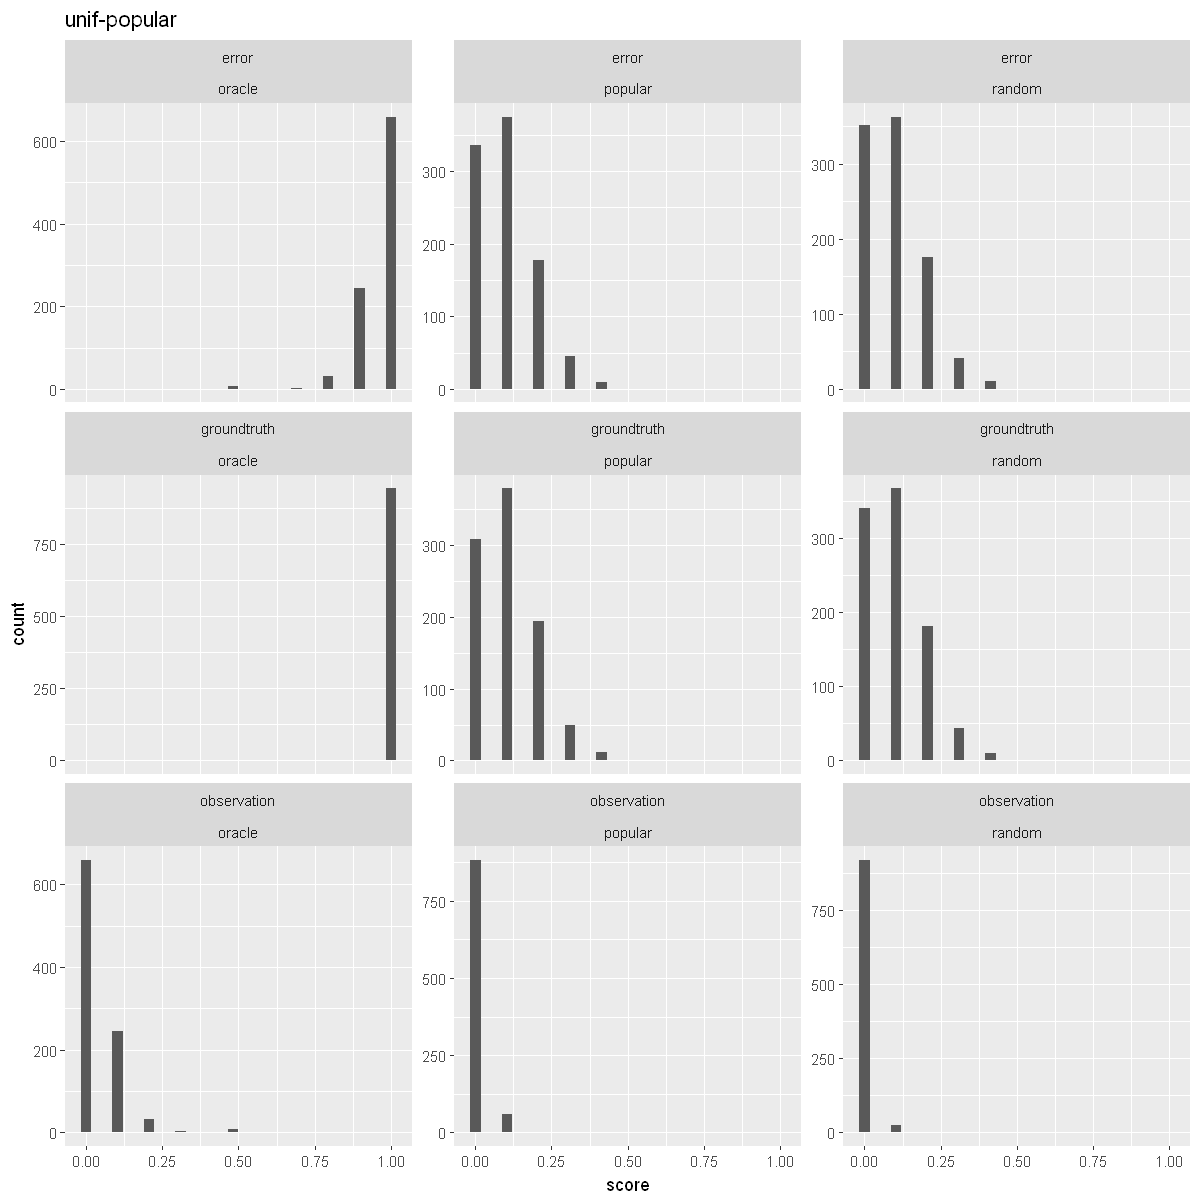

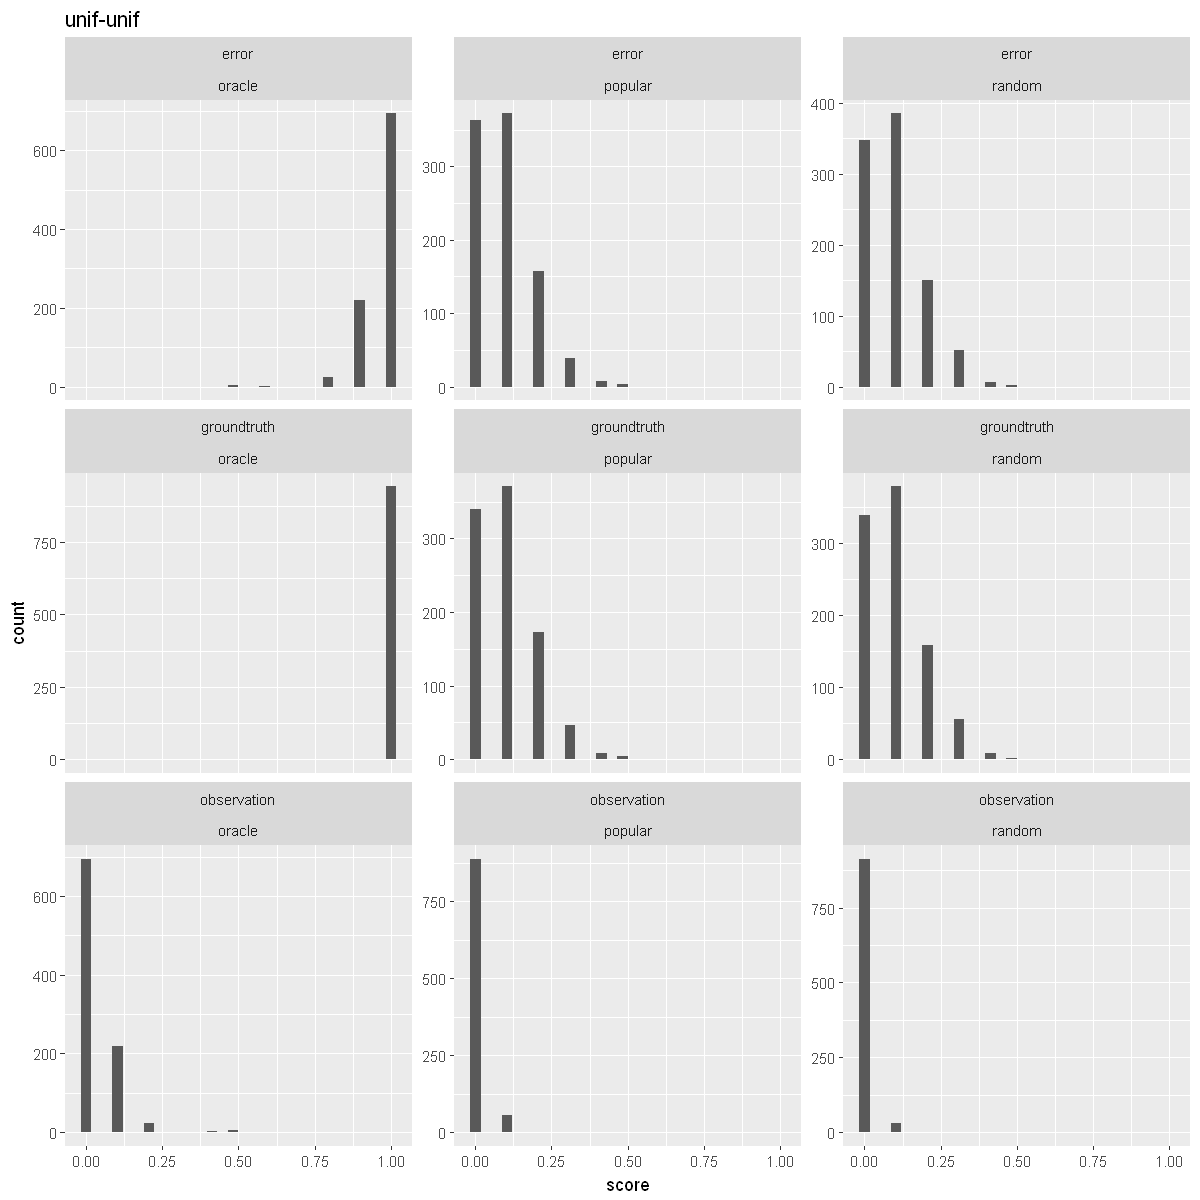

In [15]:
ggplot(filter(eval.results.plot, metric=="precision", strategy=='ibp-popular')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "ibp-popular")

ggplot(filter(eval.results.plot, metric=="precision", strategy=='ibp-unif')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "ibp-unif")

ggplot(filter(eval.results.plot, metric=="precision", strategy=='unif-popular')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "unif-popular")

ggplot(filter(eval.results.plot, metric=="precision", strategy=='unif-unif')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "unif-unif")

## Recall

In [16]:
mean.error %>%
    filter(metric=="recall")

strategy,algorithm,metric,ME,MAE,RMSE
ibp-popular,oracle,recall,0.02884927,0.03869901,0.04642550
ibp-popular,popular,recall,0.02216401,0.03522872,0.04367824
ibp-popular,random,recall,0.01171701,0.01897570,0.02161758
ibp-unif,oracle,recall,0.03782047,0.04174352,0.04814057
ibp-unif,popular,recall,0.03321302,0.03818703,0.04320200
...,...,...,...,...,...
unif-popular,popular,recall,0.002247609,0.008523214,0.01463164
unif-popular,random,recall,0.004184904,0.006739055,0.01114719
unif-unif,oracle,recall,0.041074018,0.047357188,0.05567543
unif-unif,popular,recall,0.002176252,0.008075723,0.01418173


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


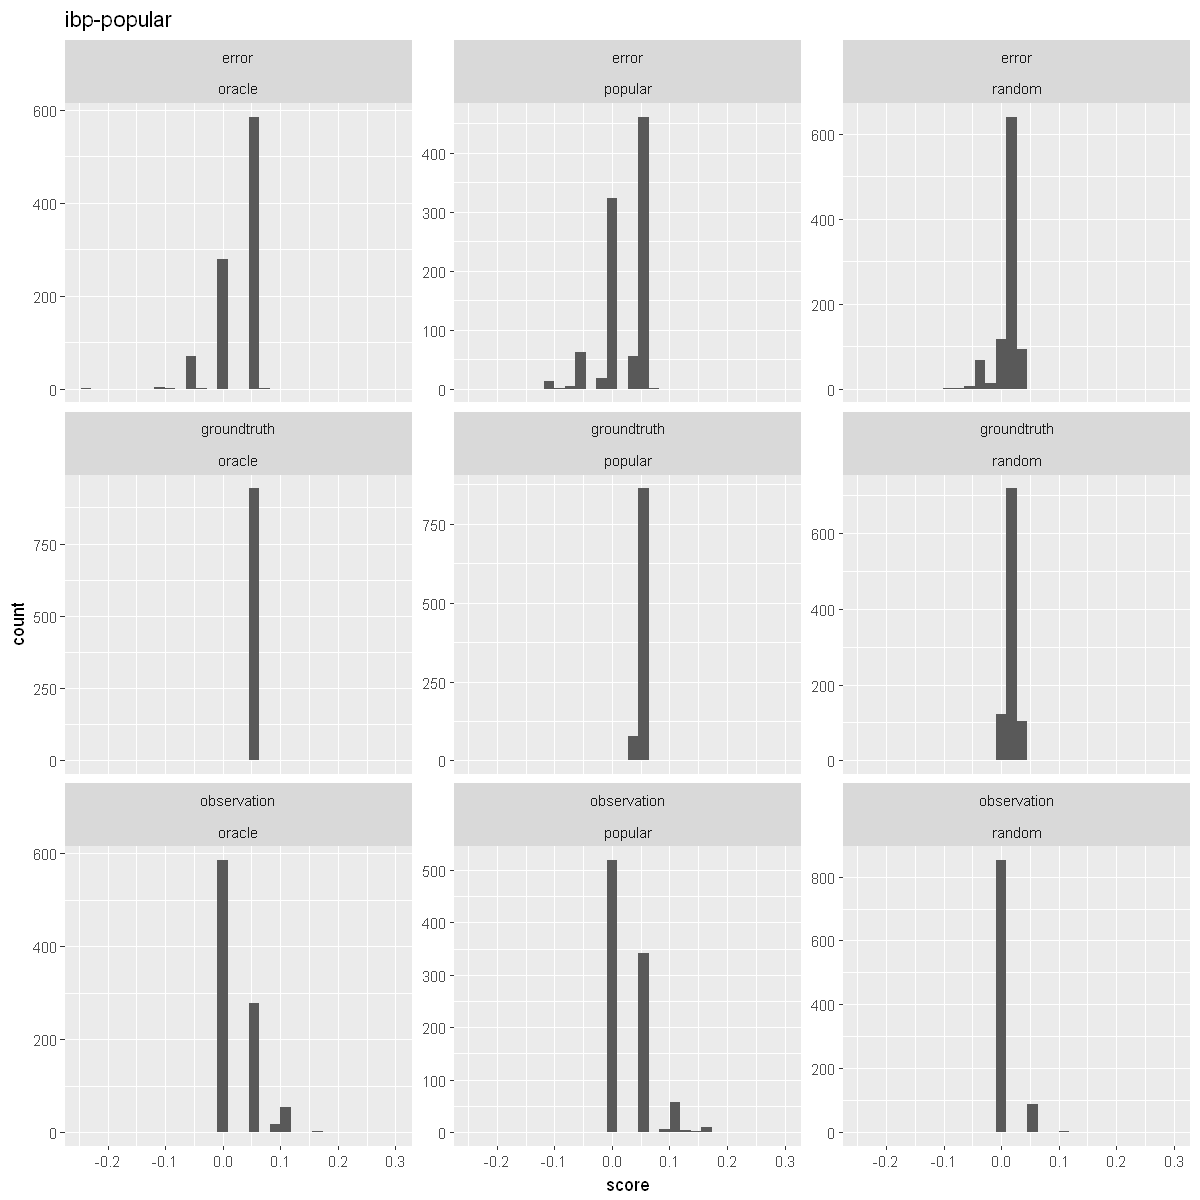

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


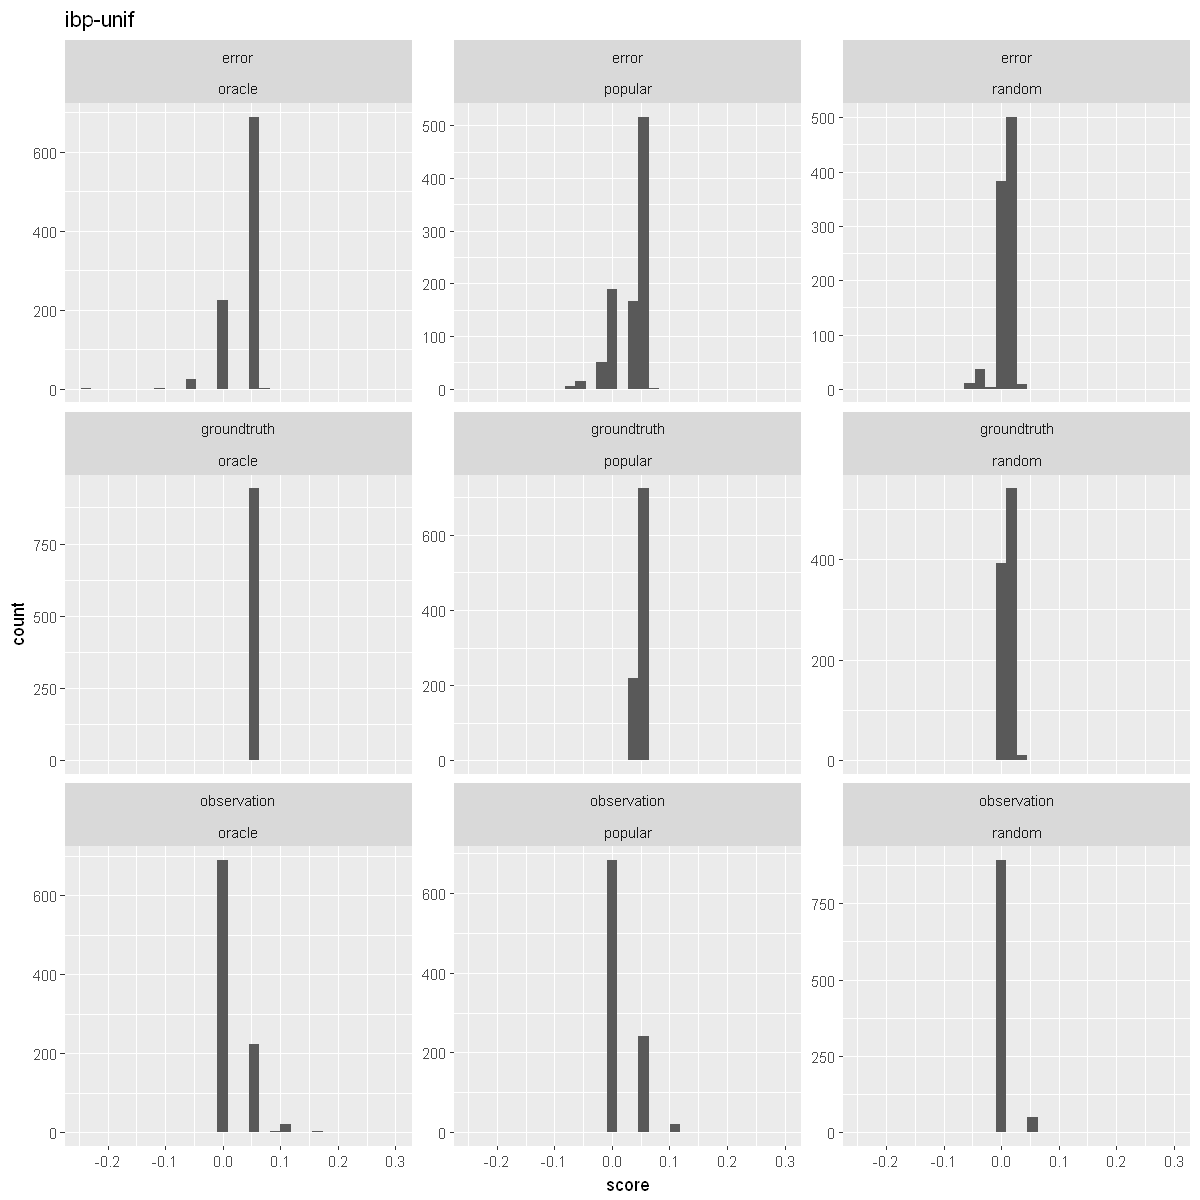

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


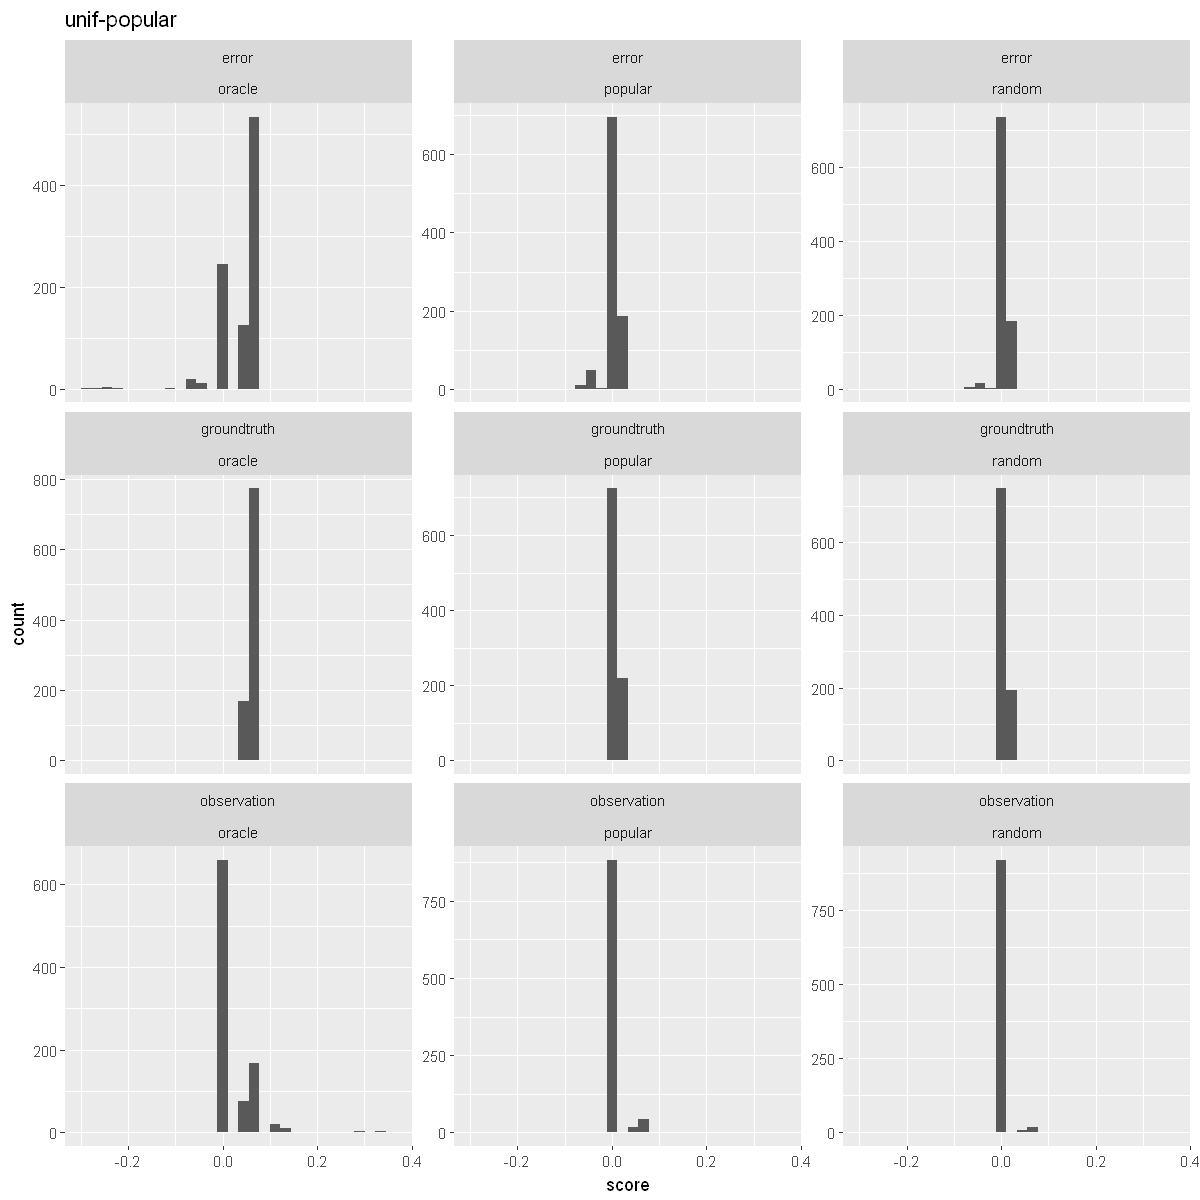

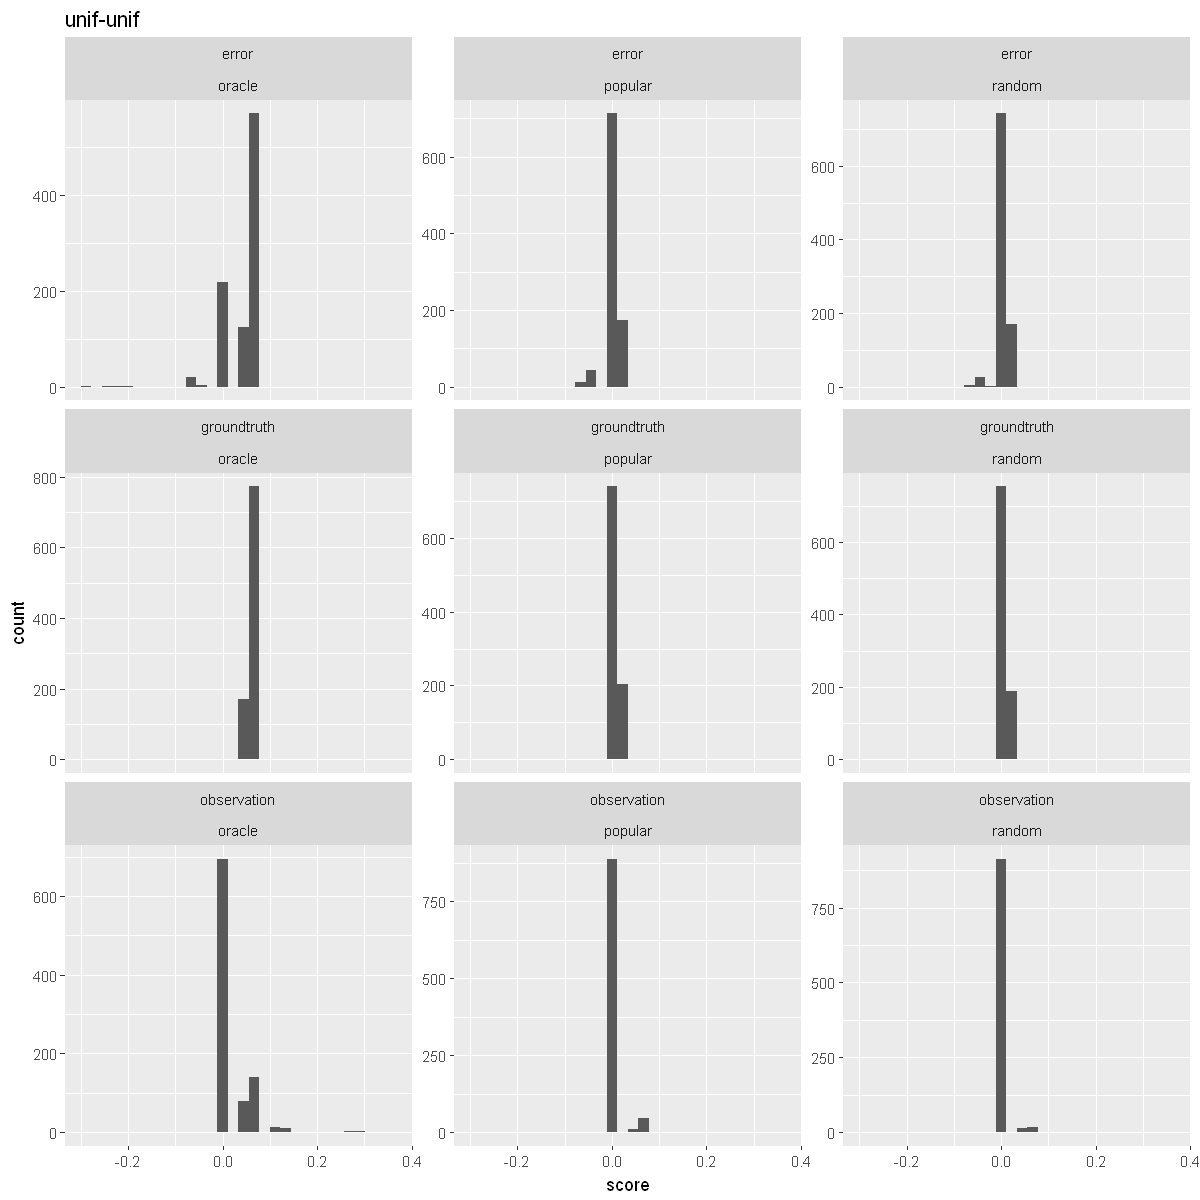

In [17]:
ggplot(filter(eval.results.plot, metric=="recall", strategy=='ibp-popular')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "ibp-popular")

ggplot(filter(eval.results.plot, metric=="recall", strategy=='ibp-unif')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "ibp-unif")

ggplot(filter(eval.results.plot, metric=="recall", strategy=='unif-popular')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "unif-popular")

ggplot(filter(eval.results.plot, metric=="recall", strategy=='unif-unif')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "unif-unif")

## Reciprocal Rank

In [18]:
mean.error %>%
    filter(metric=="reciprocal.rank")

strategy,algorithm,metric,ME,MAE,RMSE
ibp-popular,oracle,reciprocal.rank,0.8785037,0.8785037,0.9078285
ibp-popular,popular,reciprocal.rank,0.8410304,0.8410304,0.8800237
ibp-popular,random,reciprocal.rank,0.4893657,0.4893657,0.5968558
ibp-unif,oracle,reciprocal.rank,0.9137646,0.9137646,0.9365845
ibp-unif,popular,reciprocal.rank,0.8390917,0.8390917,0.8804855
...,...,...,...,...,...
unif-popular,popular,reciprocal.rank,0.2192644,0.2192644,0.3612789
unif-popular,random,reciprocal.rank,0.2229031,0.2229031,0.3673745
unif-unif,oracle,reciprocal.rank,0.9162147,0.9162147,0.9370235
unif-unif,popular,reciprocal.rank,0.2068415,0.2068415,0.3490998


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


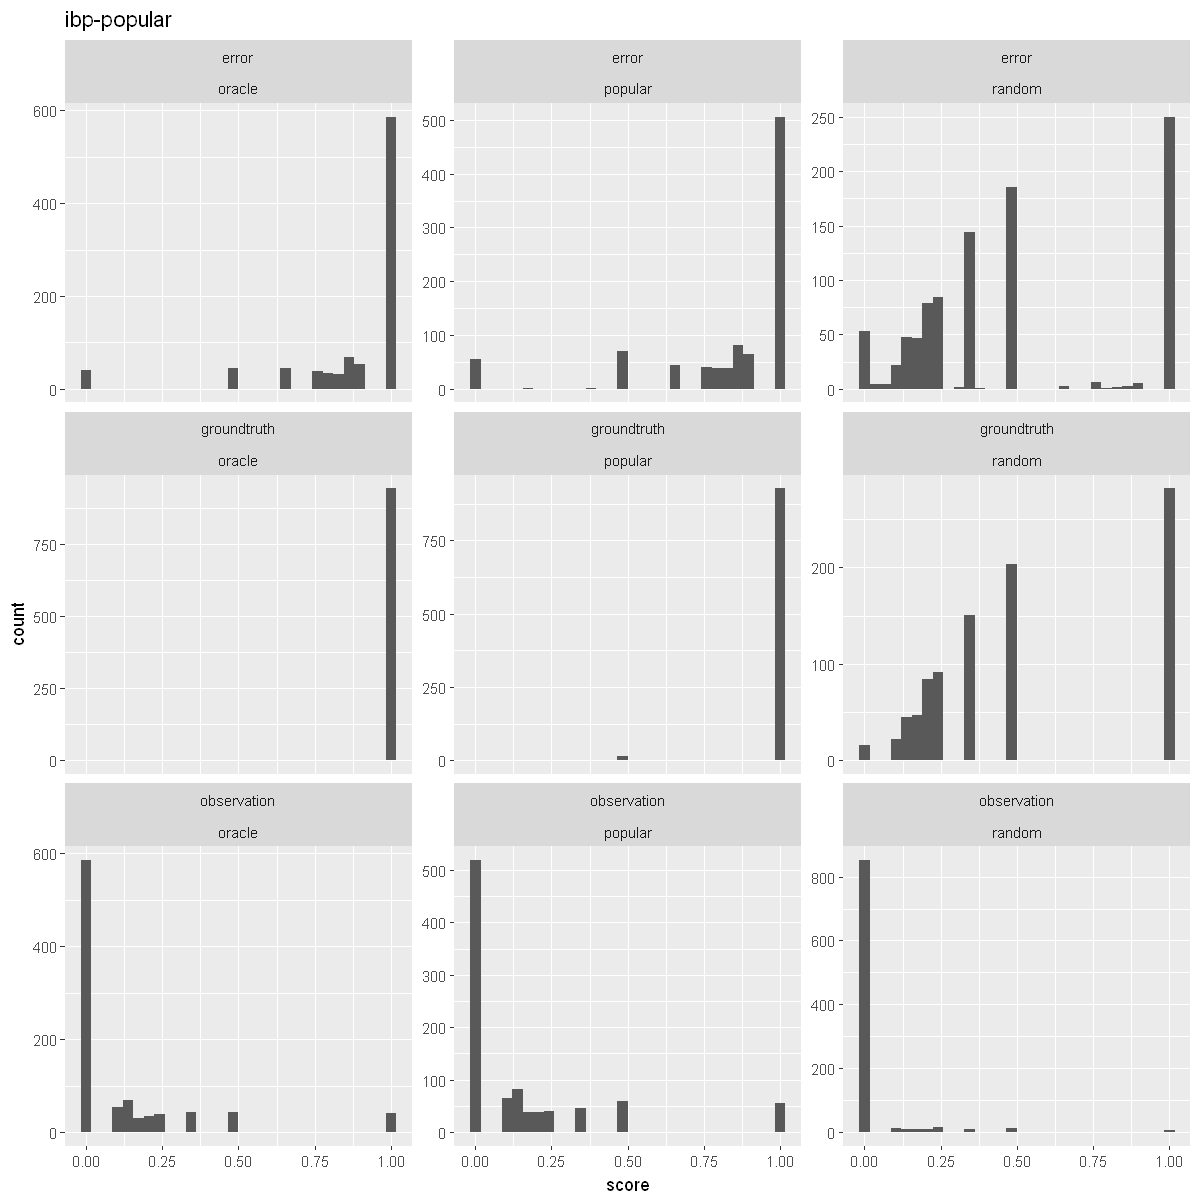

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


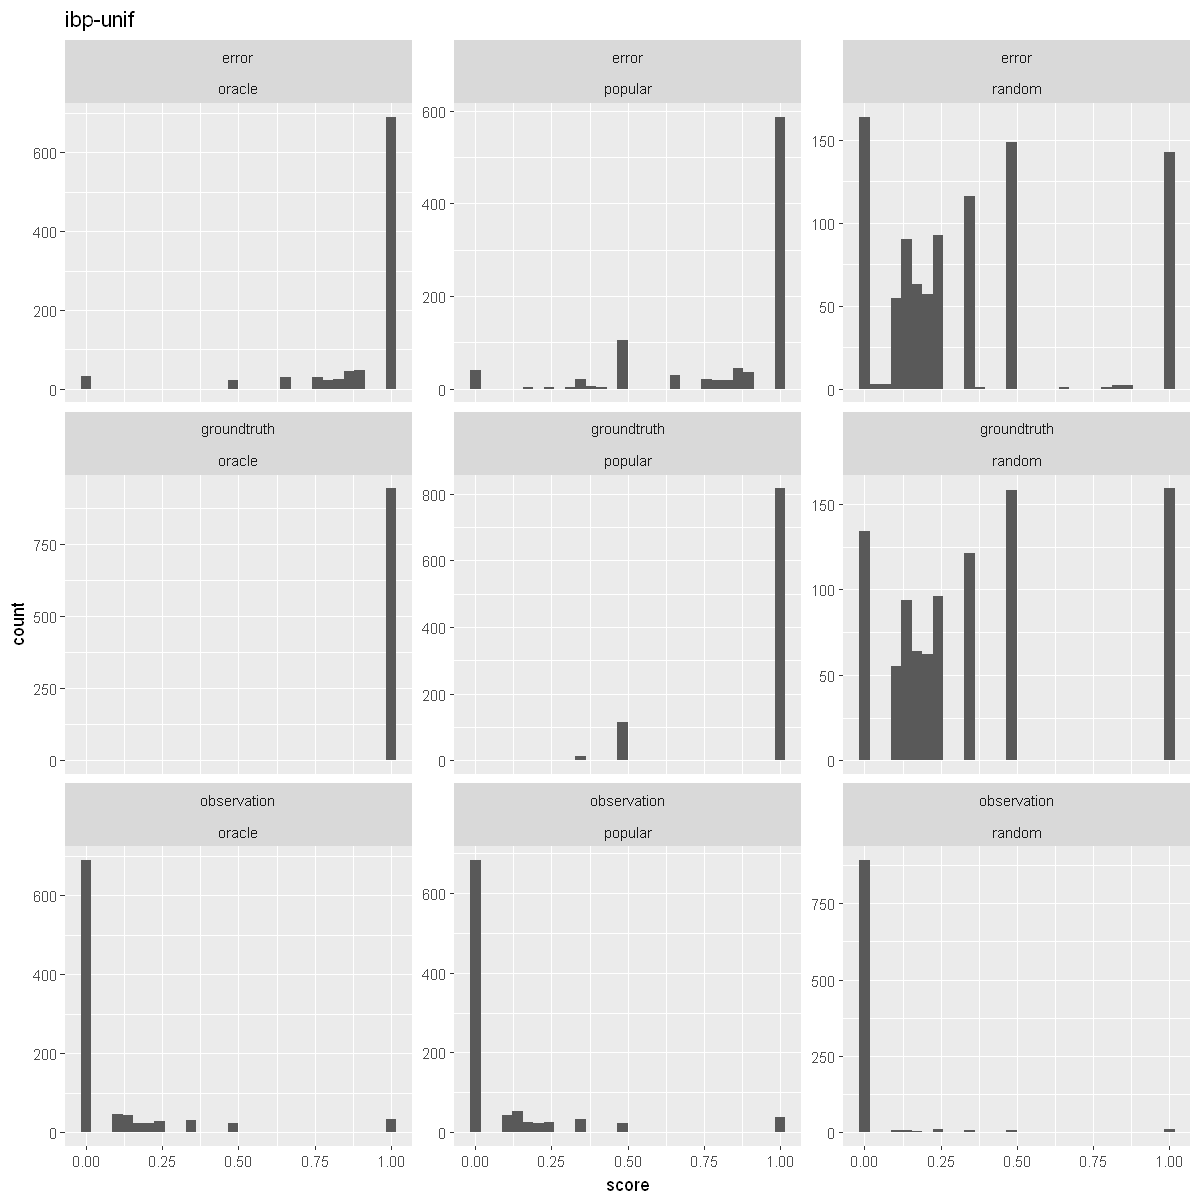

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


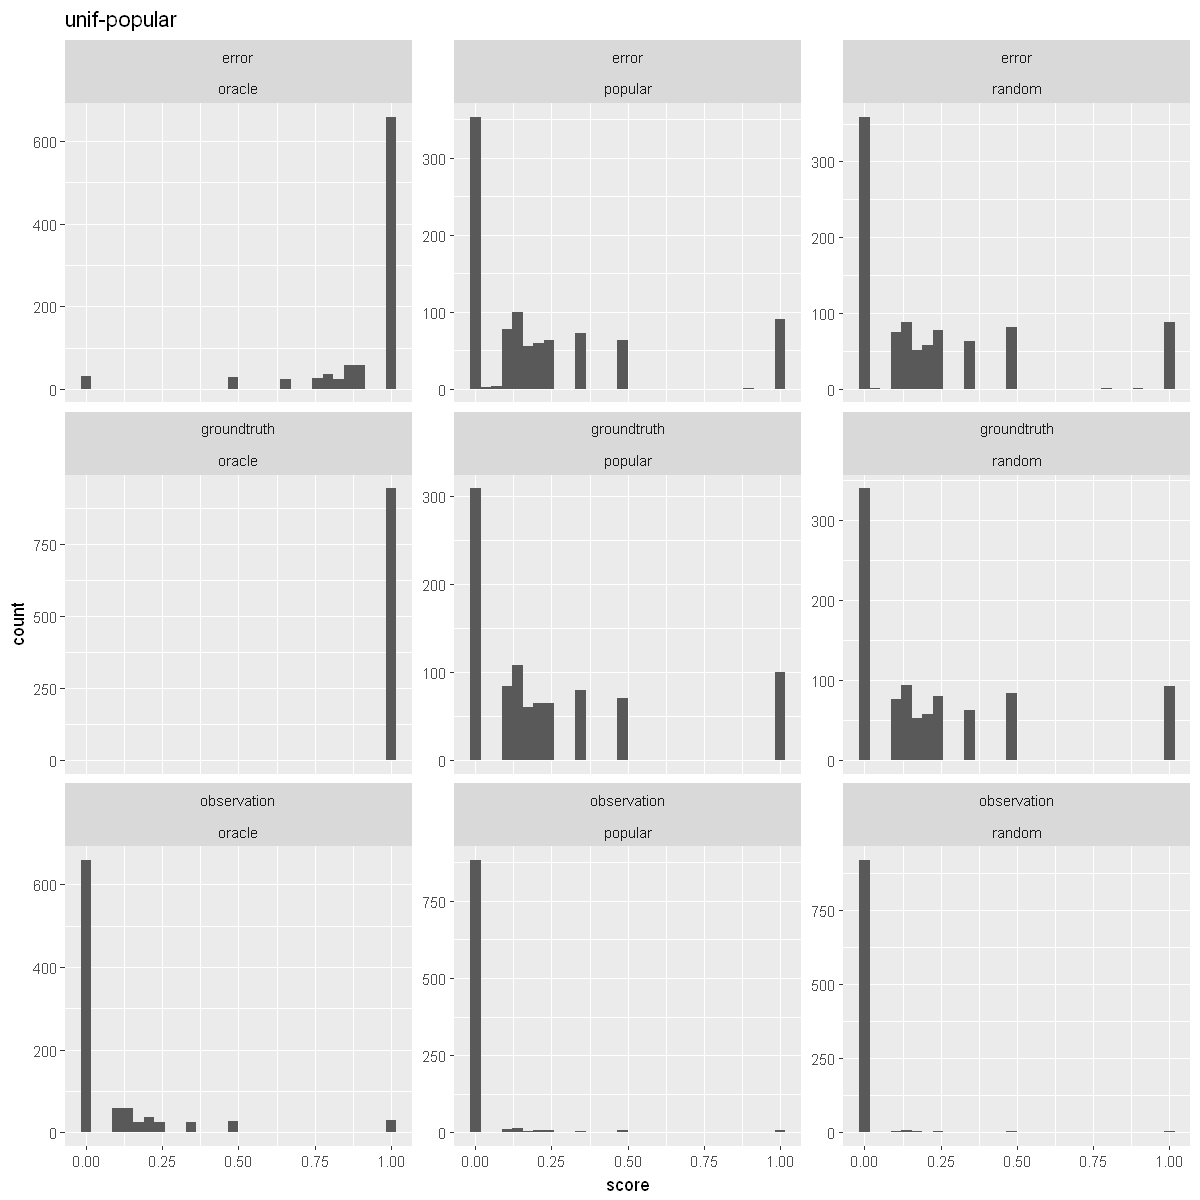

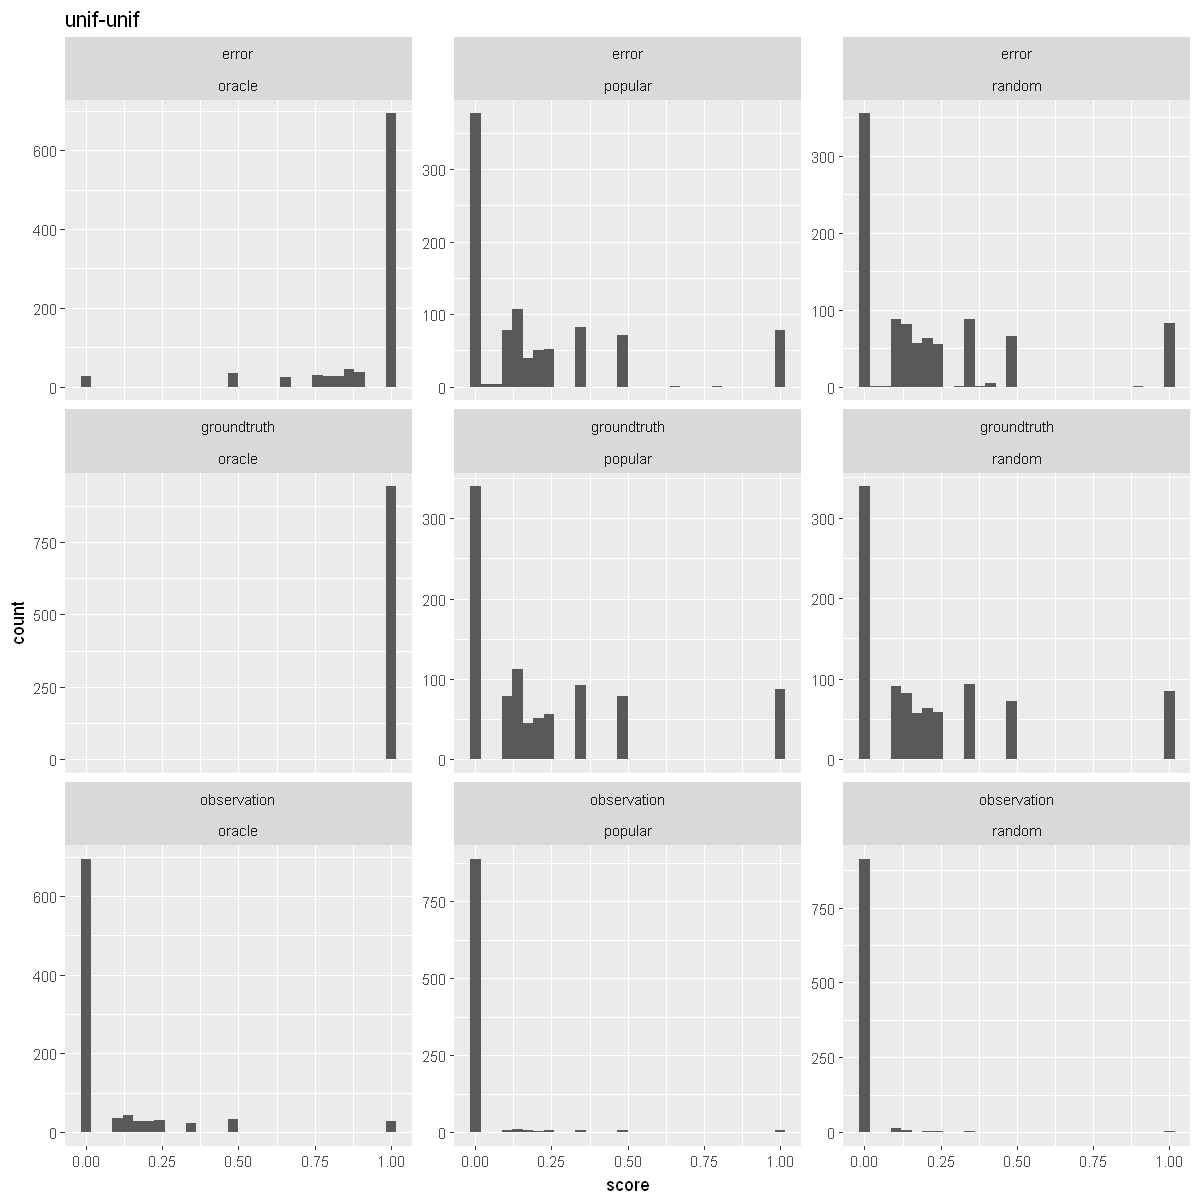

In [19]:
ggplot(filter(eval.results.plot, metric=="reciprocal.rank", strategy=='ibp-popular')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "ibp-popular")

ggplot(filter(eval.results.plot, metric=="reciprocal.rank", strategy=='ibp-unif')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "ibp-unif")

ggplot(filter(eval.results.plot, metric=="reciprocal.rank", strategy=='unif-popular')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "unif-popular")

ggplot(filter(eval.results.plot, metric=="reciprocal.rank", strategy=='unif-unif')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "unif-unif")

## Average Precision

In [20]:
mean.error %>%
    filter(metric=="avg.precision")

strategy,algorithm,metric,ME,MAE,RMSE
ibp-popular,oracle,avg.precision,0.8840214,0.8840214,0.9087165
ibp-popular,popular,avg.precision,0.8293448,0.8313500,0.8646539
ibp-popular,random,avg.precision,0.4262980,0.4328204,0.4893103
ibp-unif,oracle,avg.precision,0.9153979,0.9153979,0.9364950
ibp-unif,popular,avg.precision,0.8296177,0.8325865,0.8597609
...,...,...,...,...,...
unif-popular,popular,avg.precision,0.2014942,0.2047614,0.3189441
unif-popular,random,avg.precision,0.2053244,0.2077734,0.3261846
unif-unif,oracle,avg.precision,0.9169893,0.9169893,0.9367682
unif-unif,popular,avg.precision,0.1921944,0.1947075,0.3121455


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


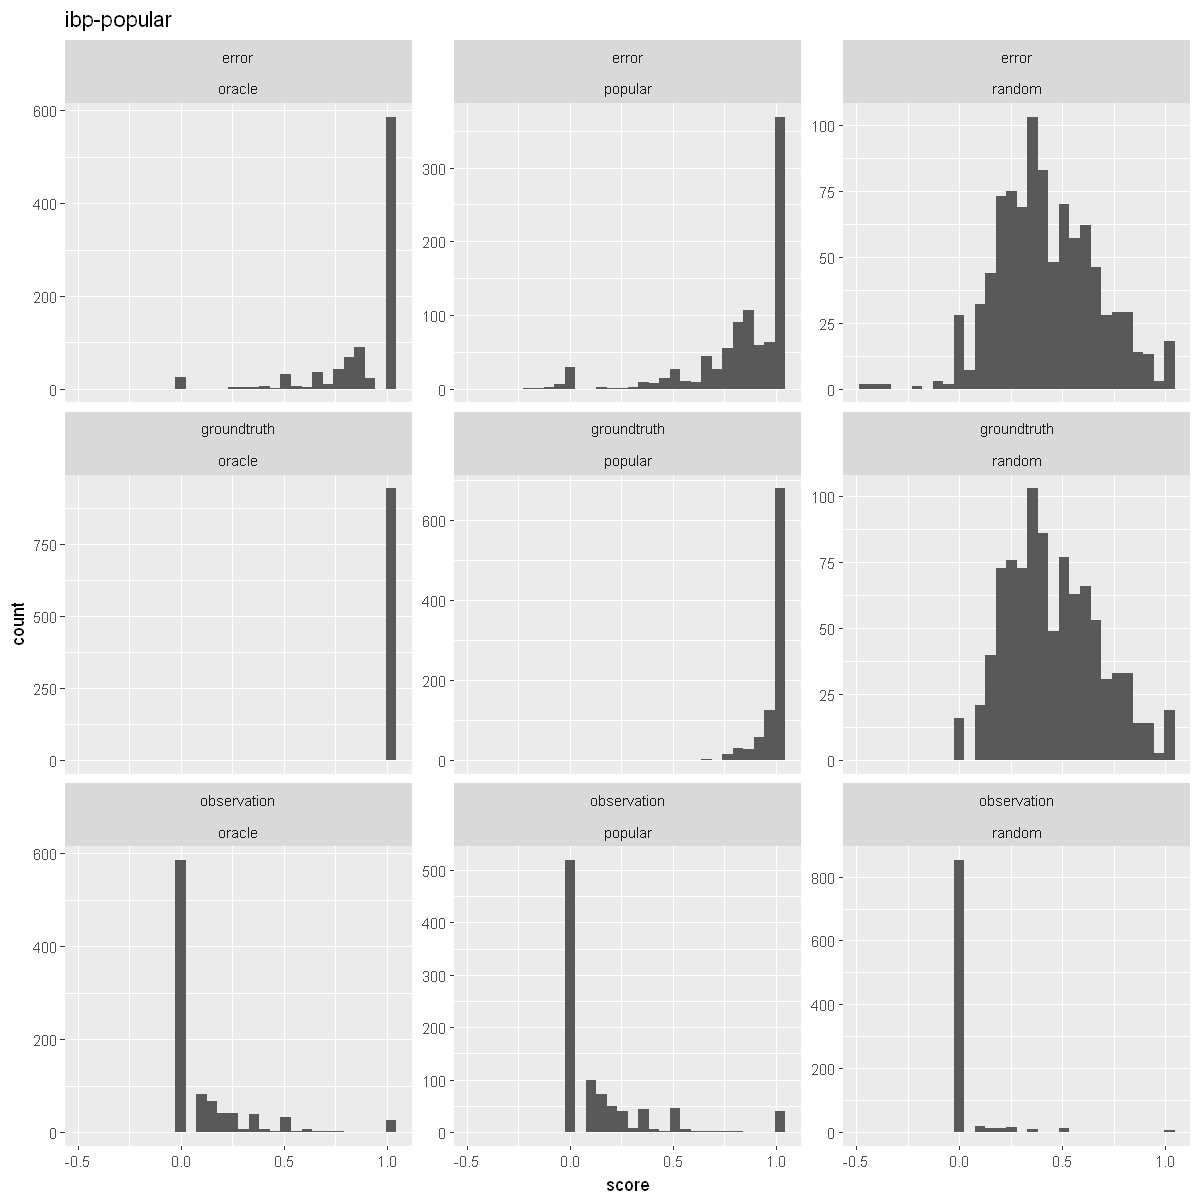

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


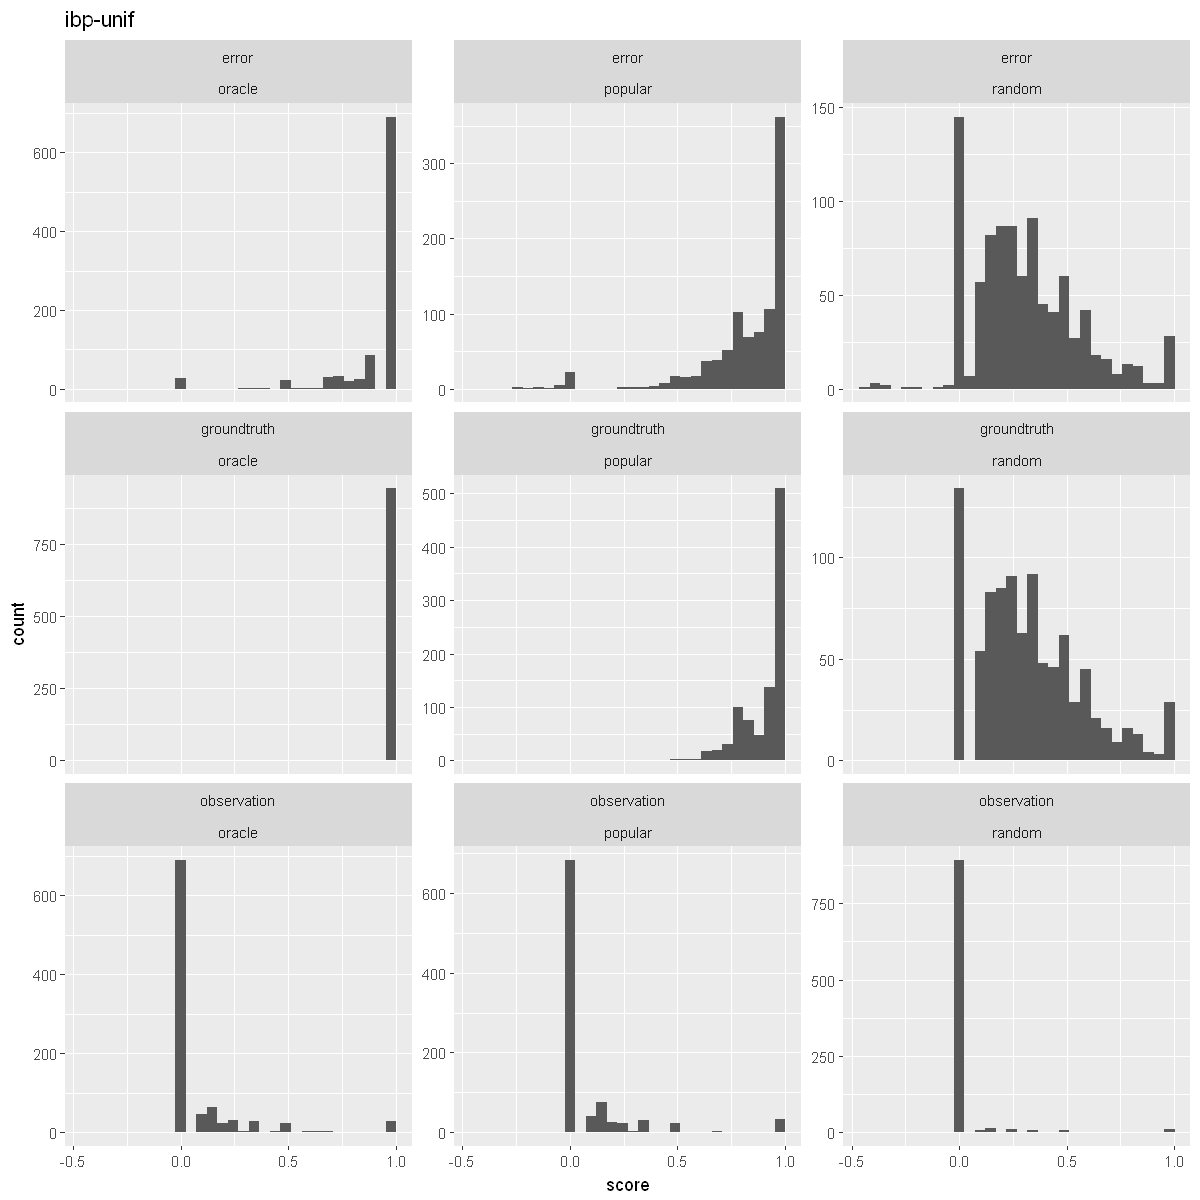

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


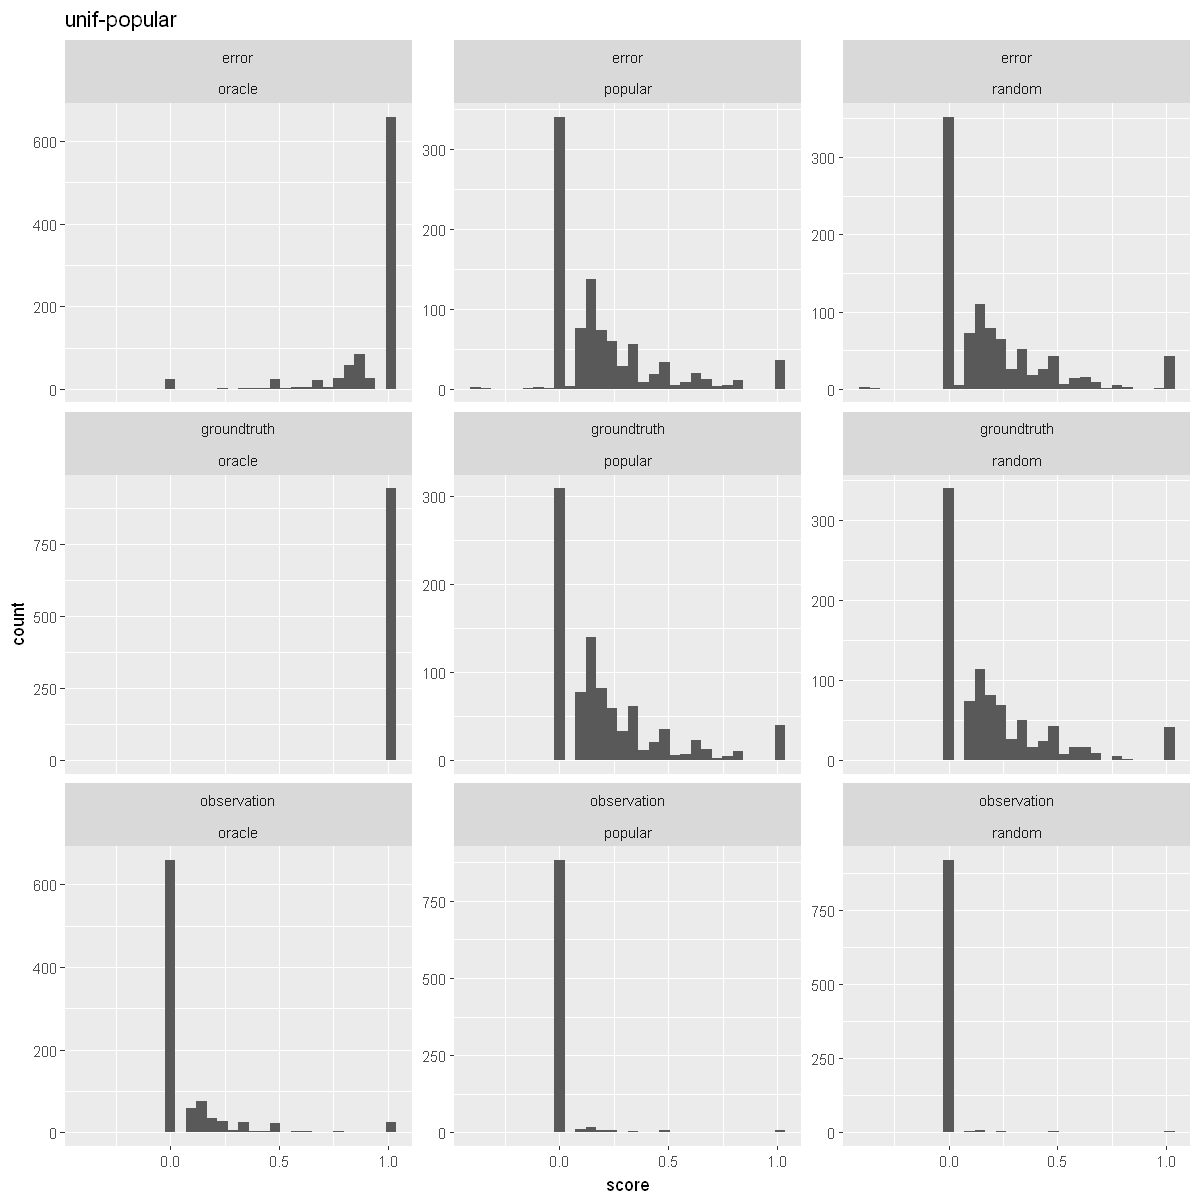

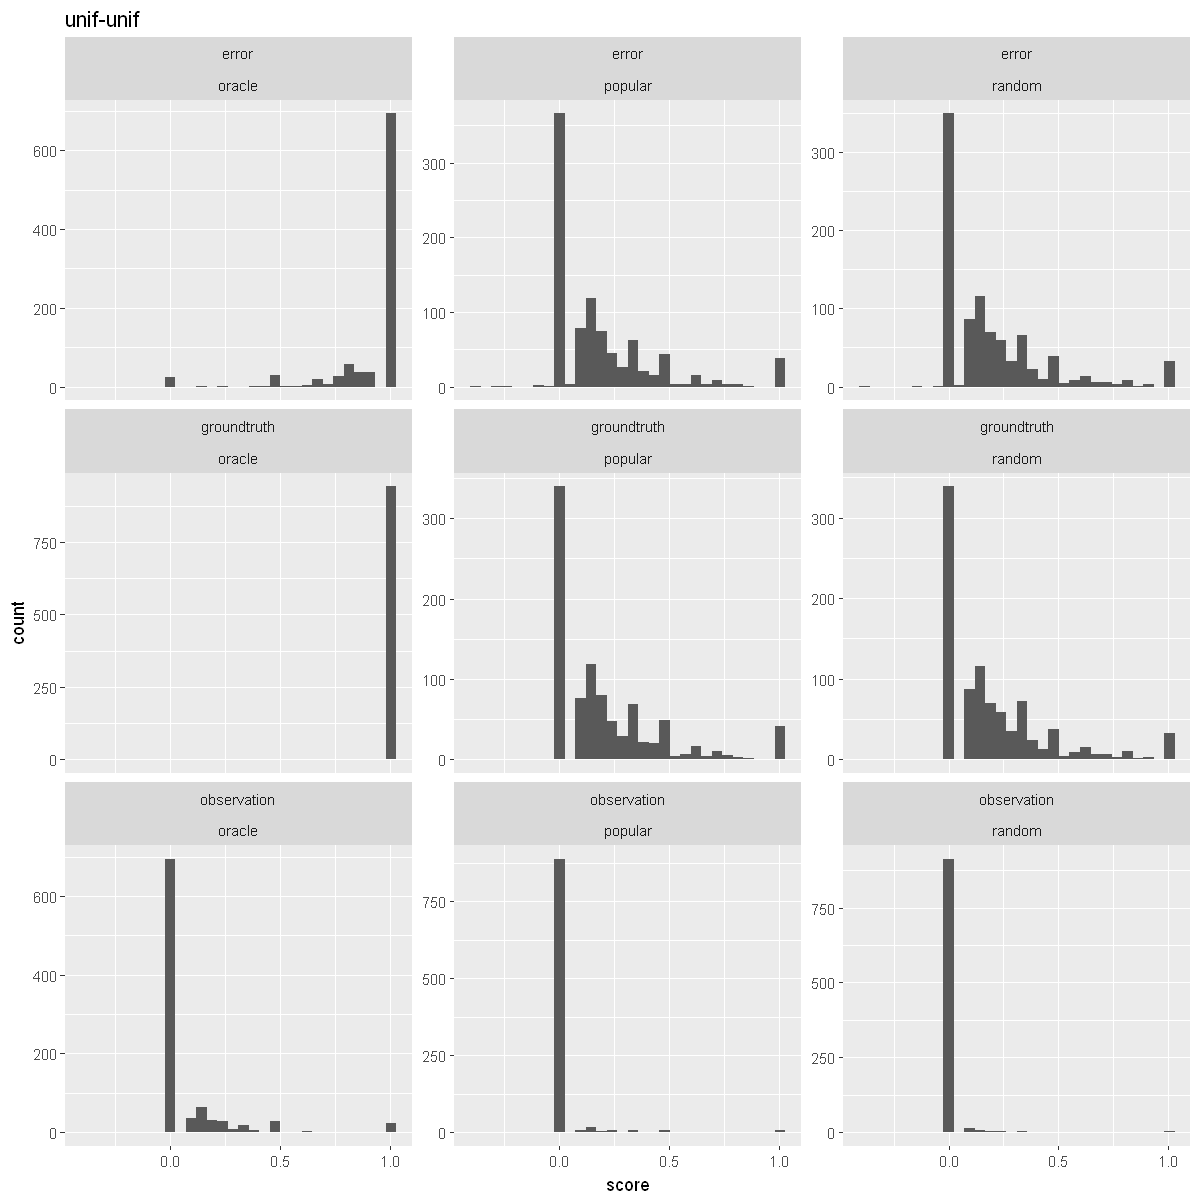

In [21]:
ggplot(filter(eval.results.plot, metric=="avg.precision", strategy=='ibp-popular')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "ibp-popular")

ggplot(filter(eval.results.plot, metric=="avg.precision", strategy=='ibp-unif')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "ibp-unif")

ggplot(filter(eval.results.plot, metric=="avg.precision", strategy=='unif-popular')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "unif-popular")

ggplot(filter(eval.results.plot, metric=="avg.precision", strategy=='unif-unif')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "unif-unif")

## Hit

In [22]:
mean.error %>%
    filter(metric=="hit")

strategy,algorithm,metric,ME,MAE,RMSE
ibp-popular,oracle,hit,0.6214511,0.6214511,0.7881013
ibp-popular,popular,hit,0.5504334,0.5504334,0.7417005
ibp-popular,random,hit,0.8865417,0.8865417,0.9415086
ibp-unif,oracle,hit,0.7316954,0.7316954,0.8553671
ibp-unif,popular,hit,0.7242204,0.7242204,0.8507851
...,...,...,...,...,...
unif-popular,popular,hit,0.6087133,0.6087133,0.7801828
unif-popular,random,hit,0.6139761,0.6139761,0.7833234
unif-unif,oracle,hit,0.7359169,0.7359169,0.8577840
unif-unif,popular,hit,0.5801756,0.5801756,0.7608535


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


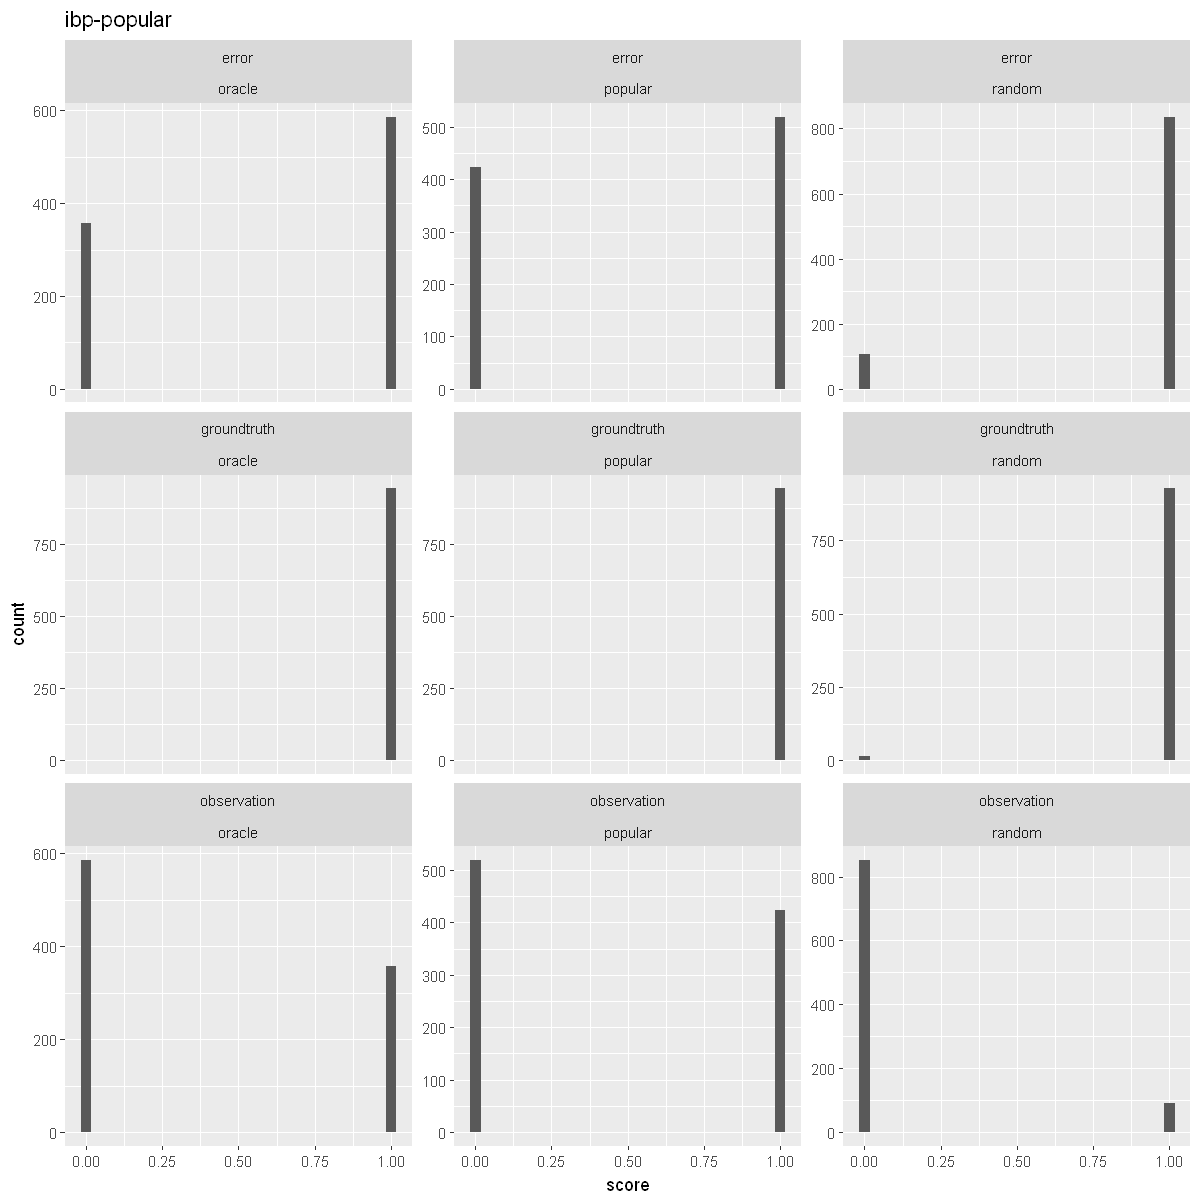

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


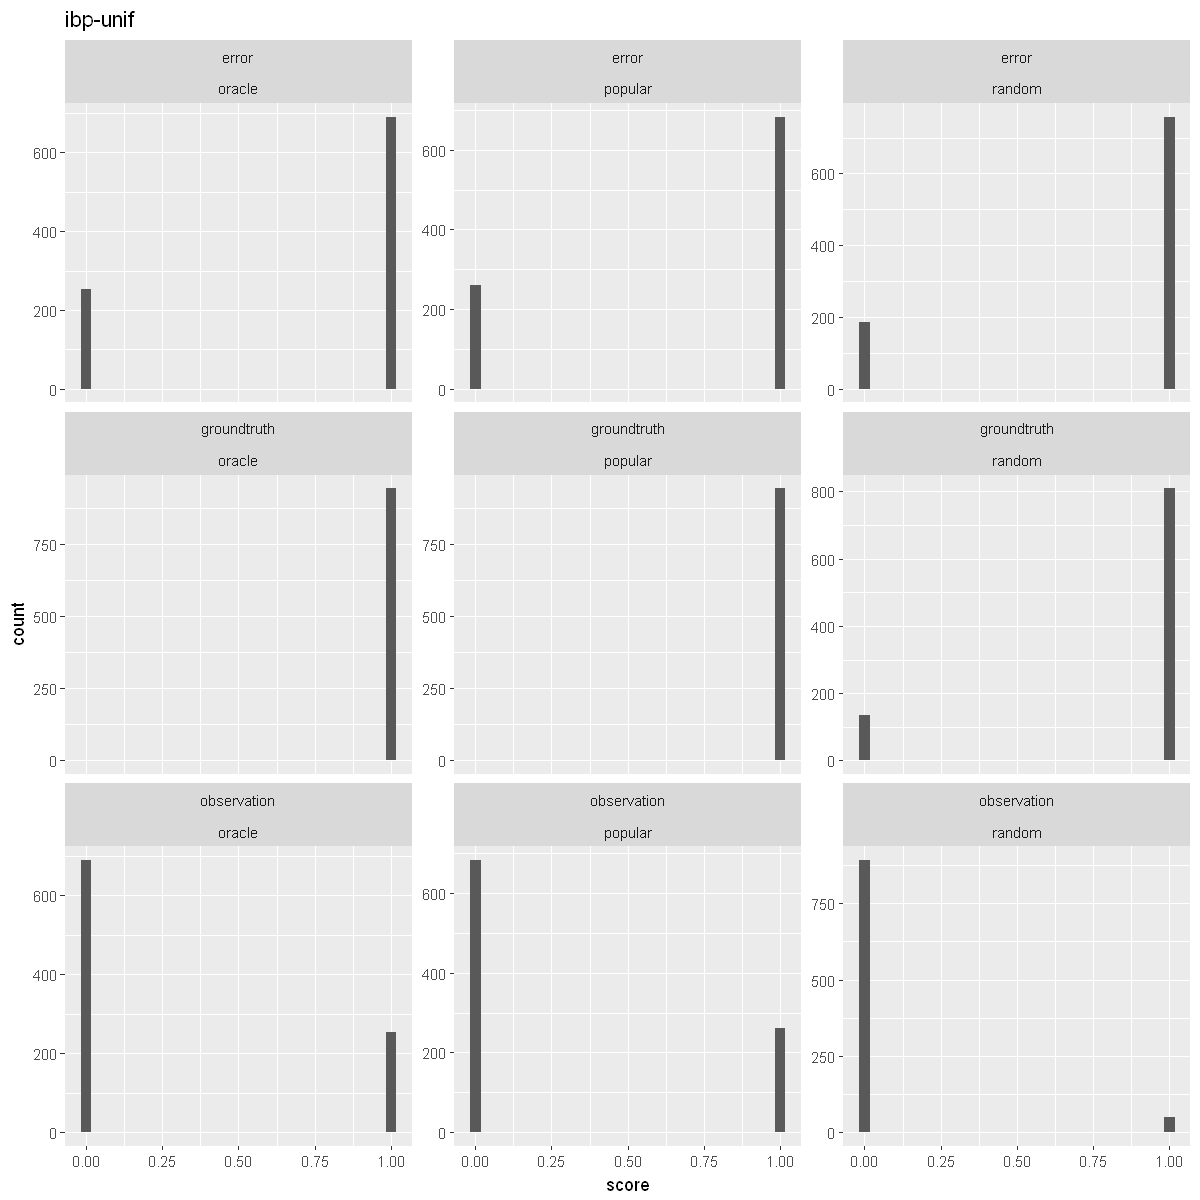

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


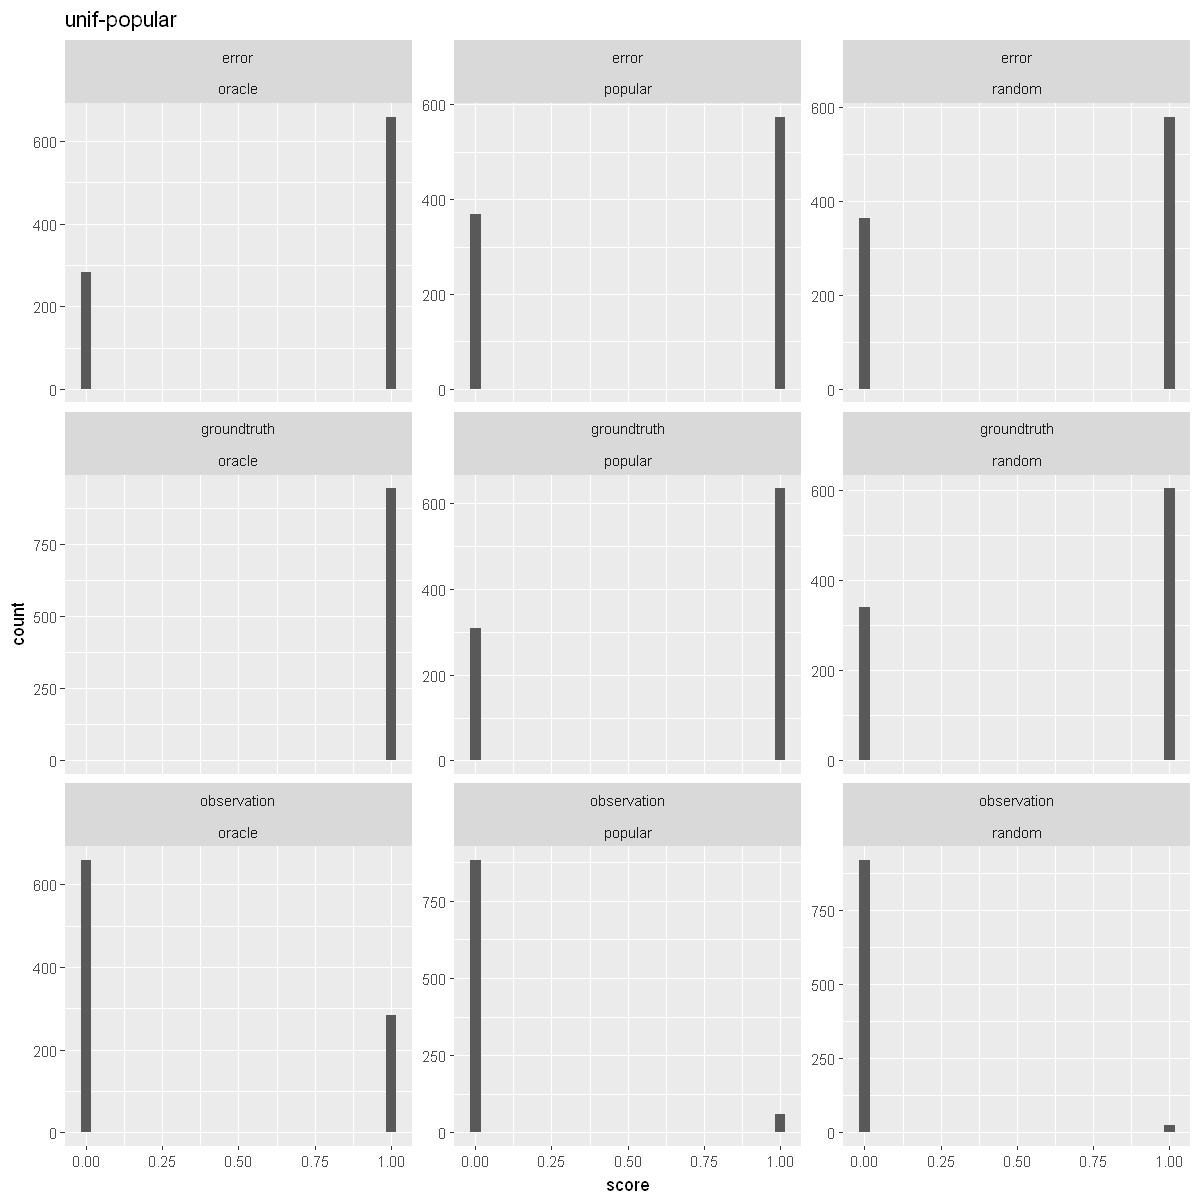

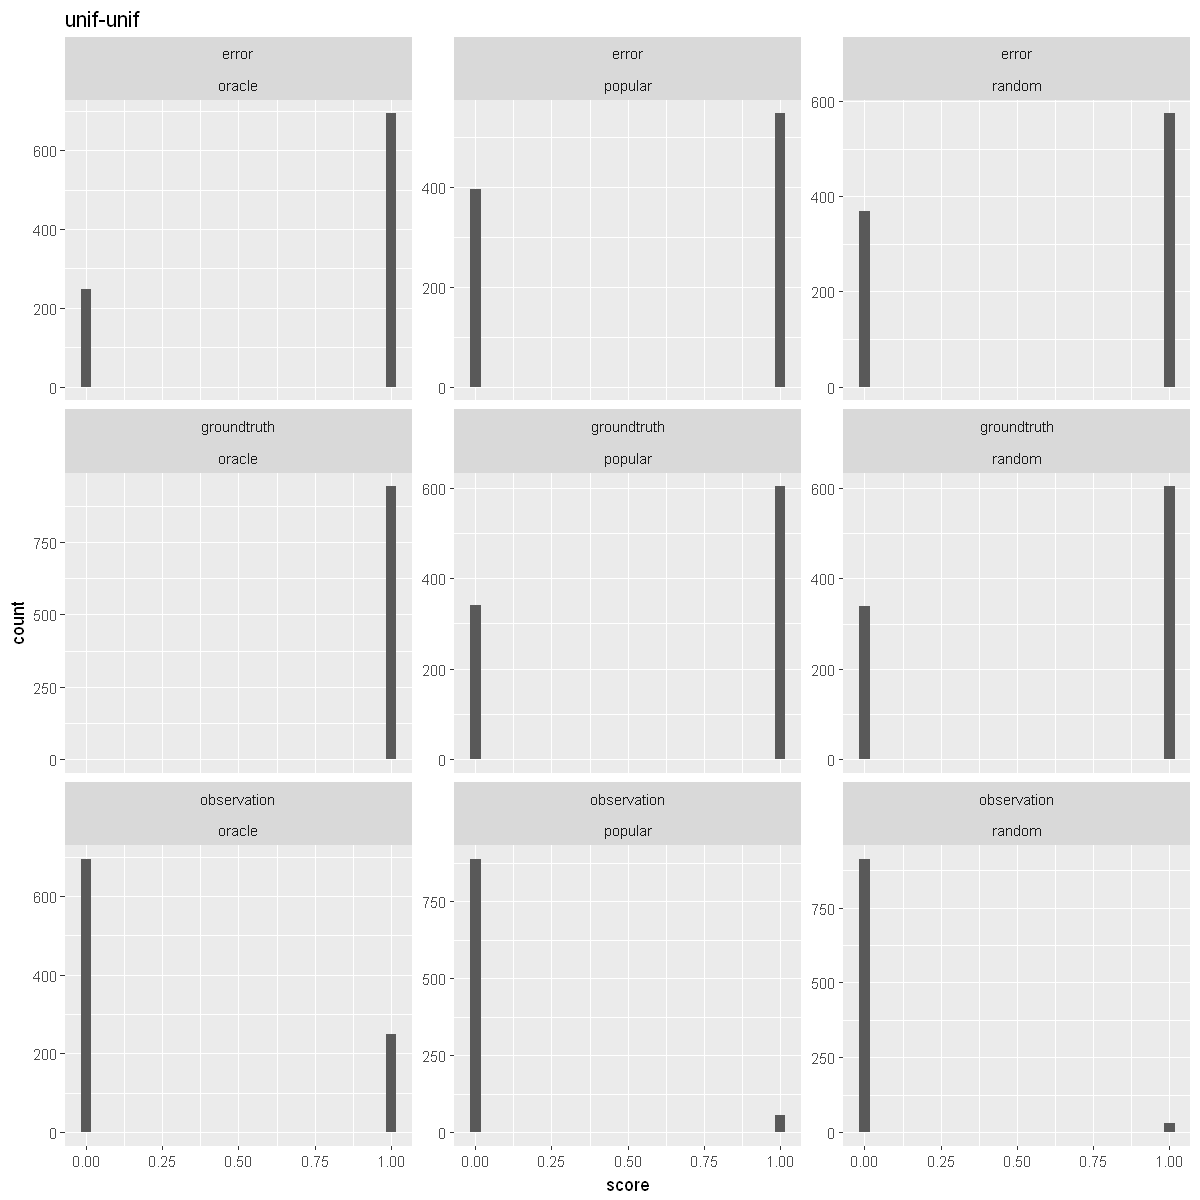

In [23]:
ggplot(filter(eval.results.plot, metric=="hit", strategy=='ibp-popular')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "ibp-popular")

ggplot(filter(eval.results.plot, metric=="hit", strategy=='ibp-unif')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "ibp-unif")

ggplot(filter(eval.results.plot, metric=="hit", strategy=='unif-popular')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "unif-popular")

ggplot(filter(eval.results.plot, metric=="hit", strategy=='unif-unif')) +
    geom_histogram(mapping=aes(x=score)) +
    facet_wrap(type~algorithm, ncol = 3, scales = 'free_y') +
    labs(title = "unif-unif")